In [1]:
import pandas as pd
import numpy as np
import os, sys, warnings, re, time, gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.dirname('../')))
from modules import eda
gc.collect()

0

In [26]:
def stripSB(x, S, B, y='logPrice'):
    fig = plt.figure(figsize=(30,15))
    fig.add_subplot(2,1,1)
    plt.xticks(rotation='vertical')
    sns.stripplot(x=x, y=y, data=S.sort_values(by=[x]), color='red', size=0.2)
    fig.add_subplot(2,1,2)
    plt.xticks(rotation='vertical')
    sns.stripplot(x=x, y=y, data=B.sort_values(by=[x]), color='blue', size=0.2)
    plt.show()
    
def colInfo(col, train=train, test=test):
    dtype = train[col].dtypes
    print(dtype)
    if dtype == 'float64' : 
        print(train[col].describe())
        print(test[col].describe())
    else:
        uniq = train[col].unique()
        if dtype == 'O' or len(uniq)<100: 
            print(train[col].value_counts(dropna=False))
            print(test[col].value_counts(dropna=False))
        else : 
            print(train[col].describe())
            print(test[col].describe())
    isna(col)
            
def isna(col, train=train, test=test):
    print('train na : ', sum(train[col].isna()))
    print('test na :', sum(test[col].isna()))

In [54]:
train['logPrice']=np.log(train.transaction_real_price)
busanTrain = train[train.city==0]
seoulTrain = train[train.city==1]
apart = 'apartment_id'
uniq = list(train[apart].unique())+list(test[apart].unique())

#### dataset load

In [3]:
%%time
path = './datasets/origin/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
subway = pd.read_csv(path+'Subways.csv')
school = pd.read_csv(path+'Schools.csv')
gc.collect()

Wall time: 8.19 s


In [12]:
%%time
train.to_hdf(path+'train.h5', 'train')
# test.to_hdf(path+'test.h5', 'test')
# subway.to_hdf(path+'subway.h5', 'subway')
# school.to_hdf(path+'school.h5', 'school')
gc.collect()

Wall time: 3.98 s


#### look data

In [10]:
allCols = train.columns.tolist()
print(allCols)

['key', 'apartment_id', 'city', 'transaction_year_month', 'transaction_date', 'year_of_completion', 'exclusive_use_area', 'floor', 'latitude', 'longitude', 'address_by_law', 'total_parking_capacity_in_site', 'total_household_count_in_sites', 'apartment_building_count_in_sites', 'tallest_building_in_sites', 'lowest_building_in_sites', 'heat_type', 'heat_fuel', 'room_id', 'supply_area', 'total_household_count_of_area_type', 'room_count', 'bathroom_count', 'front_door_structure', 'transaction_real_price']


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601458 entries, 0 to 1601457
Data columns (total 25 columns):
key                                   1601458 non-null int64
apartment_id                          1601458 non-null int64
city                                  1601458 non-null int64
transaction_year_month                1601458 non-null int64
transaction_date                      1601458 non-null object
year_of_completion                    1601458 non-null int64
exclusive_use_area                    1601458 non-null float64
floor                                 1601458 non-null int64
latitude                              1601458 non-null float64
longitude                             1601458 non-null float64
address_by_law                        1601458 non-null int64
total_parking_capacity_in_site        1509645 non-null float64
total_household_count_in_sites        1601458 non-null int64
apartment_building_count_in_sites     1601458 non-null int64
tallest_building_in_site

In [43]:
set(train.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [44]:
set(test.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3918 entries, 0 to 3917
Data columns (total 25 columns):
key                                   3918 non-null int64
apartment_id                          3918 non-null int64
city                                  3918 non-null int64
transaction_year_month                3918 non-null int64
transaction_date                      3918 non-null object
year_of_completion                    3918 non-null int64
exclusive_use_area                    3918 non-null float64
floor                                 3918 non-null int64
latitude                              3918 non-null float64
longitude                             3918 non-null float64
address_by_law                        3918 non-null int64
total_parking_capacity_in_site        3547 non-null float64
total_household_count_in_sites        3918 non-null int64
apartment_building_count_in_sites     3918 non-null int64
tallest_building_in_sites             3917 non-null float64
lowest_build

In [9]:
train.describe()

key  apartment_id          city  transaction_year_month  \
count  1.601458e+06  1.601458e+06  1.601458e+06            1.601458e+06   
mean   8.007597e+05  7.781149e+03  6.252877e-01            2.012416e+05   
std    4.623505e+05  7.384526e+03  4.840487e-01            3.775998e+02   
min    0.000000e+00  3.000000e+00  0.000000e+00            2.006010e+05   
25%    4.003642e+05  1.606000e+03  0.000000e+00            2.009070e+05   
50%    8.007305e+05  5.579000e+03  1.000000e+00            2.013080e+05   
75%    1.201101e+06  1.106300e+04  1.000000e+00            2.016030e+05   
max    1.605373e+06  5.026400e+04  1.000000e+00            2.018100e+05   

       year_of_completion  exclusive_use_area         floor      latitude  \
count        1.601458e+06        1.601458e+06  1.601458e+06  1.601458e+06   
mean         1.998645e+03        7.946863e+01  1.013031e+01  3.666195e+01   
std          8.444635e+00        2.800054e+01  7.194129e+00  1.157632e+00   
min          1.962000e+03        1.639600e+01 -4.000000e+00  3.504879e+01   
25%          1.993000e+03        5.984000e+01  5.000000e+00  3.518907e+01   
50%          1.999000e+03        8.446000e+01  9.000000e+00  3.749926e+01   
75%          2.005000e+03        8.498000e+01  1.400000e+01  3.756554e+01   
max          2.018000e+03        2.954340e+02  8.000000e+01  3.768763e+01   

          longitude  address_by_law           ...            \
count  1.601458e+06    1.601458e+06           ...             
mean   1.277745e+02    1.704232e+09           ...             
std    1.005557e+00    7.216393e+08           ...             
min    1.268061e+02    1.111012e+09           ...             
25%    1.269782e+02    1.135011e+09           ...             
50%    1.270743e+02    1.165011e+09           ...             
75%    1.290298e+02    2.632010e+09           ...             
max    1.292376e+02    2.671033e+09           ...             

       total_household_count_in_sites  apartment_building_count_in_sites  \
count                    1.601458e+06                       1.601458e+06   
mean                     1.181628e+03                       1.274730e+01   
std                      1.128092e+03                       1.399157e+01   
min                      9.900000e+01                       1.000000e+00   
25%                      4.160000e+02                       4.000000e+00   
50%                      8.110000e+02                       9.000000e+00   
75%                      1.590000e+03                       1.600000e+01   
max                      6.864000e+03                       1.240000e+02   

       tallest_building_in_sites  lowest_building_in_sites       room_id  \
count               1.601449e+06              1.601449e+06  1.601458e+06   
mean                2.077357e+01              1.393617e+01  3.481310e+04   
std                 8.750388e+00              6.785973e+00  4.157775e+04   
min                 5.000000e+00              1.000000e+00  1.300000e+01   
25%                 1.500000e+01              9.000000e+00  6.610000e+03   
50%                 2.000000e+01              1.300000e+01  2.048400e+04   
75%                 2.500000e+01              1.700000e+01  4.221900e+04   
max                 8.000000e+01              7.000000e+01  1.922520e+05   

        supply_area  total_household_count_of_area_type    room_count  \
count  1.601458e+06                        1.601458e+06  1.600767e+06   
mean   1.020035e+02                        2.931756e+02  2.951266e+00   
std    3.306049e+01                        3.237872e+02  6.653449e-01   
min    2.010000e+01                        0.000000e+00  0.000000e+00   
25%    7.993000e+01                        9.000000e+01  3.000000e+00   
50%    1.029600e+02                        1.940000e+02  3.000000e+00   
75%    1.115400e+02                        3.840000e+02  3.000000e+00   
max    4.234000e+02                        2.960000e+03  8.000000e+00   

       bathroom_count  transaction_real_price  
co

In [8]:
train.head(5)

key  apartment_id  city  transaction_year_month transaction_date  \
0    0          5584     1                  200601            11~20   
1    1          5584     1                  200601            11~20   
2    2          5059     1                  200601            11~20   
3    3          2816     1                  200601            11~20   
4    4          2816     1                  200601            11~20   

   year_of_completion  exclusive_use_area  floor   latitude   longitude  \
0                1999               47.43      6  37.585965  127.000231   
1                1999               44.37      8  37.585965  127.000231   
2                1992               54.70      8  37.580511  127.014016   
3                1993               64.66     11  37.580324  127.011788   
4                1993              106.62      7  37.580324  127.011788   

            ...            lowest_building_in_sites   heat_type  heat_fuel  \
0           ...                                 4.0  individual        gas   
1           ...                                 4.0  individual        gas   
2           ...                                 9.0  individual        gas   
3           ...                                11.0  individual        gas   
4           ...                                11.0  individual        gas   

   room_id  supply_area  total_household_count_of_area_type room_count  \
0    91120        65.63                                  46        1.0   
1    91119        61.39                                  10        2.0   
2     8430        72.36                                 201        2.0   
3     5839        87.30                                 284        2.0   
4     5836       127.74                                 112        4.0   

  bathroom_count  front_door_structure  transaction_real_price  
0            1.0              corridor               215000000  
1            1.0              corridor               200000000  
2            1.0              corridor               168000000  
3            1.0              corridor               165000000  
4            2.0              stairway               280000000  

[5 rows x 25 columns]

###### EDA 진행을 위해 -1로 임시 널 처리

In [ ]:
train.fillna(-1, inplace=True)

#### target distribution

In [32]:
col = 'apartment_id'
colInfo(col)

int64
count    1.601458e+06
mean     7.781149e+03
std      7.384526e+03
min      3.000000e+00
25%      1.606000e+03
50%      5.579000e+03
75%      1.106300e+04
max      5.026400e+04
Name: apartment_id, dtype: float64
count     3918.000000
mean      9749.125064
std       9086.376371
min          3.000000
25%       2943.250000
50%       6341.000000
75%      15053.000000
max      50264.000000
Name: apartment_id, dtype: float64
train na :  0
test na : 0


In [33]:
for df in (train, test):
    print(df[col].value_counts())

16156    17000
8001     15915
7922      6360
7771      6328
8002      6273
5513      6226
1547      6219
3618      5951
11181     5710
17001     5526
1284      5473
18543     5321
895       5256
15985     5106
5047      4776
7772      4617
5280      4395
16629     4236
903       3996
1066      3737
5686      3629
10438     3607
15953     3601
8702      3537
122       3512
3735      3462
9079      3458
15668     3440
2982      3428
1559      3417
         ...  
33368        4
36919        4
37298        3
37467        3
37242        3
37470        3
36413        3
26888        3
36502        3
37459        3
36948        3
37176        2
37173        2
36907        2
36798        2
37171        2
3751         2
38422        2
36881        1
36955        1
36938        1
38419        1
36027        1
36649        1
37469        1
37357        1
37359        1
37447        1
22241        1
316          1
Name: apartment_id, Length: 3906, dtype: int64
1066     1
709      1
701      1
9366 

In [34]:
trainUniq = train[col].unique()
testUniq = test[col].unique()
print(set(trainUniq)-set(testUniq))
print(set(testUniq)-set(trainUniq))

set()
{36224, 38465, 22247, 36841, 37353, 37354, 37297, 37431, 26553, 37180, 33373, 37086}


In [35]:
col = 'city'
colInfo(col)

int64
1    1001372
0     600086
Name: city, dtype: int64
1    2637
0    1281
Name: city, dtype: int64
train na :  0
test na : 0


In [41]:
print(600086/1001372)
print(1281/2637)

0.5992638100526079
0.4857792946530148


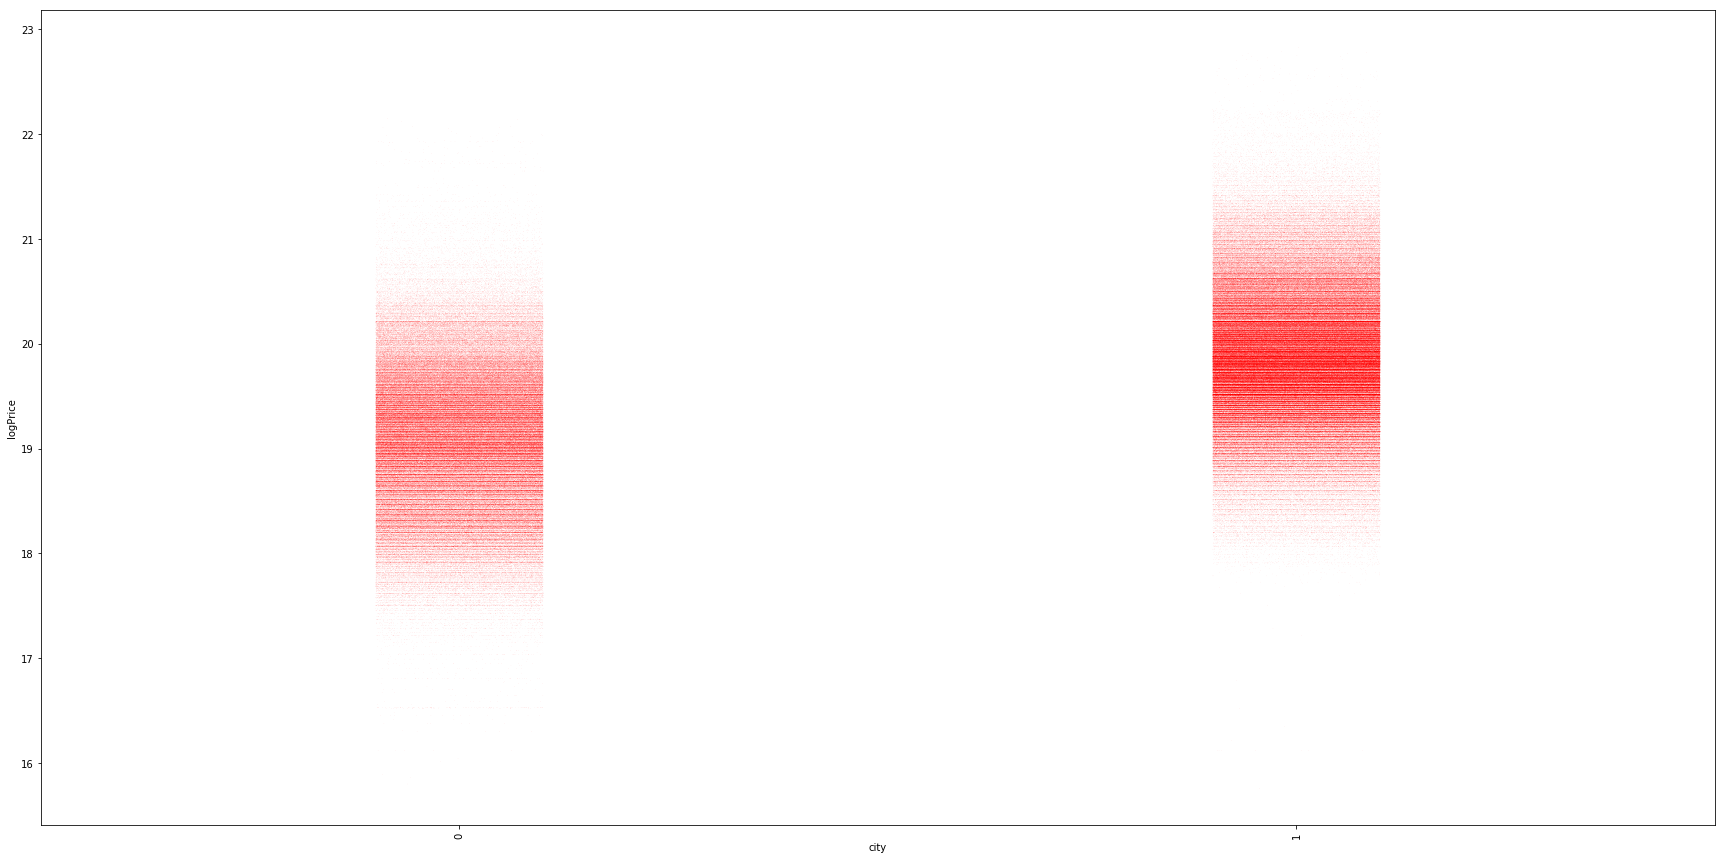

In [40]:
fig = plt.figure(figsize=(30,15))
plt.xticks(rotation='vertical')
sns.stripplot(x=col, y='logPrice', data=train.sort_values(by=[col]), color='red', size=0.2)
plt.show()

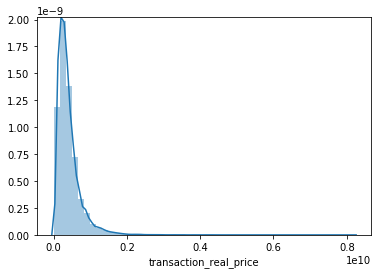

In [19]:
sns.distplot(train.transaction_real_price)

In [20]:
print("Skewed: ", train.transaction_real_price.skew())
print("Kurtosis: ", train.transaction_real_price.kurt())

Skewed:  3.1472918937559937
Kurtosis:  21.545215328939587


In [11]:
train.transaction_real_price.describe()

count    1.601458e+06
mean     4.021752e+08
std      3.223861e+08
min      7.000000e+06
25%      1.990000e+08
50%      3.240000e+08
75%      5.000000e+08
max      8.200000e+09
Name: transaction_real_price, dtype: float64

In [14]:
(7.000000e+06)/10000
'''
단위가 만원이 아니라 원인 거 같은데. 
근데 서울/부산에서 700만원짜리 집이라니 개꿀 재테크네
7M ~ 8.2B
'''

700.0

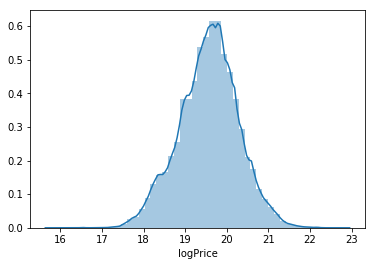

In [16]:
train['logPrice']=np.log(train.transaction_real_price)
sns.distplot(train.logPrice)

In [17]:
print("Skewed: ", train['logPrice'].skew())
print("Kurtosis: ", train['logPrice'].kurt())

Skewed:  -0.12241208310603337
Kurtosis:  0.11216751595908114


In [22]:
len(train['apartment_id'].unique())

3906

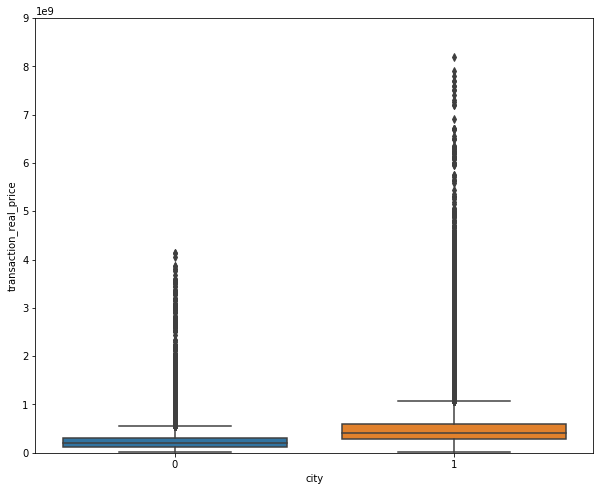

In [35]:
var = 'city'
data = pd.concat([train['transaction_real_price'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="transaction_real_price", data=data)
fig.axis(ymin=0, ymax=9000000000);

#### relation with target

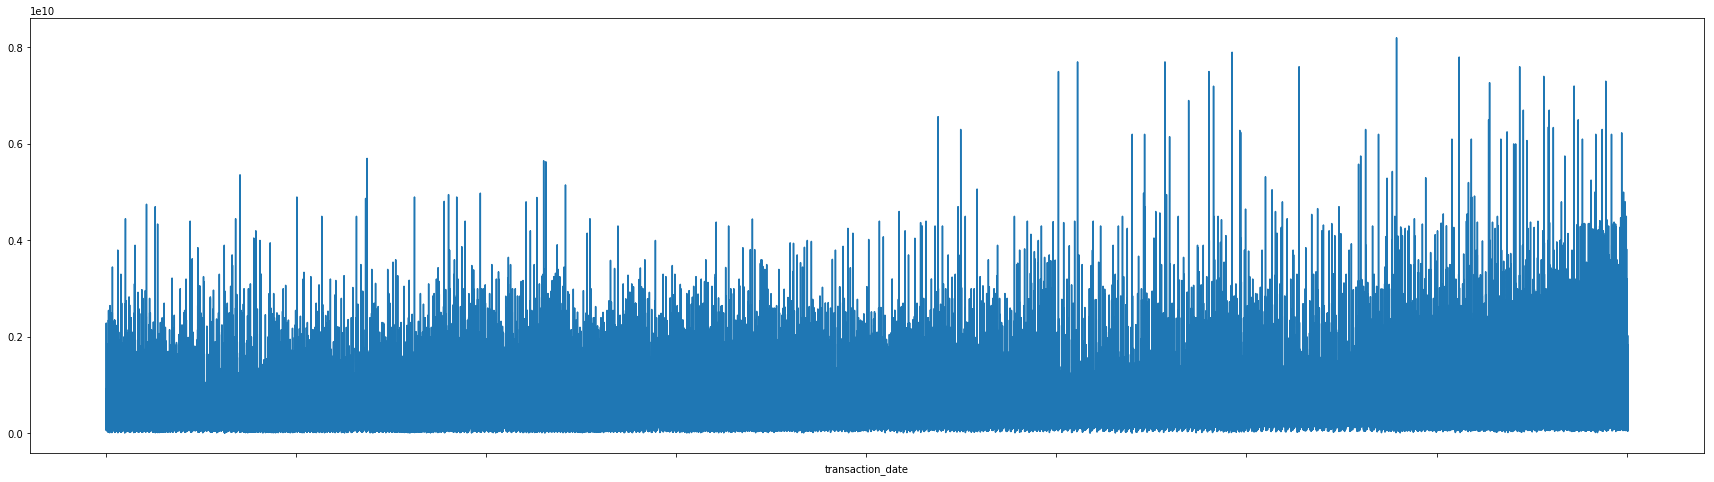

In [22]:
#거래일자
train.set_index("transaction_date")['transaction_real_price'].plot(figsize=(30,8))

In [42]:
col = 'transaction_year_month'
colInfo(col)

int64
count    1.601458e+06
mean     2.012416e+05
std      3.775998e+02
min      2.006010e+05
25%      2.009070e+05
50%      2.013080e+05
75%      2.016030e+05
max      2.018100e+05
Name: transaction_year_month, dtype: float64
count      3918.000000
mean     201806.033180
std          26.135513
min      200912.000000
25%      201808.000000
50%      201809.000000
75%      201809.000000
max      201810.000000
Name: transaction_year_month, dtype: float64
train na :  0
test na : 0


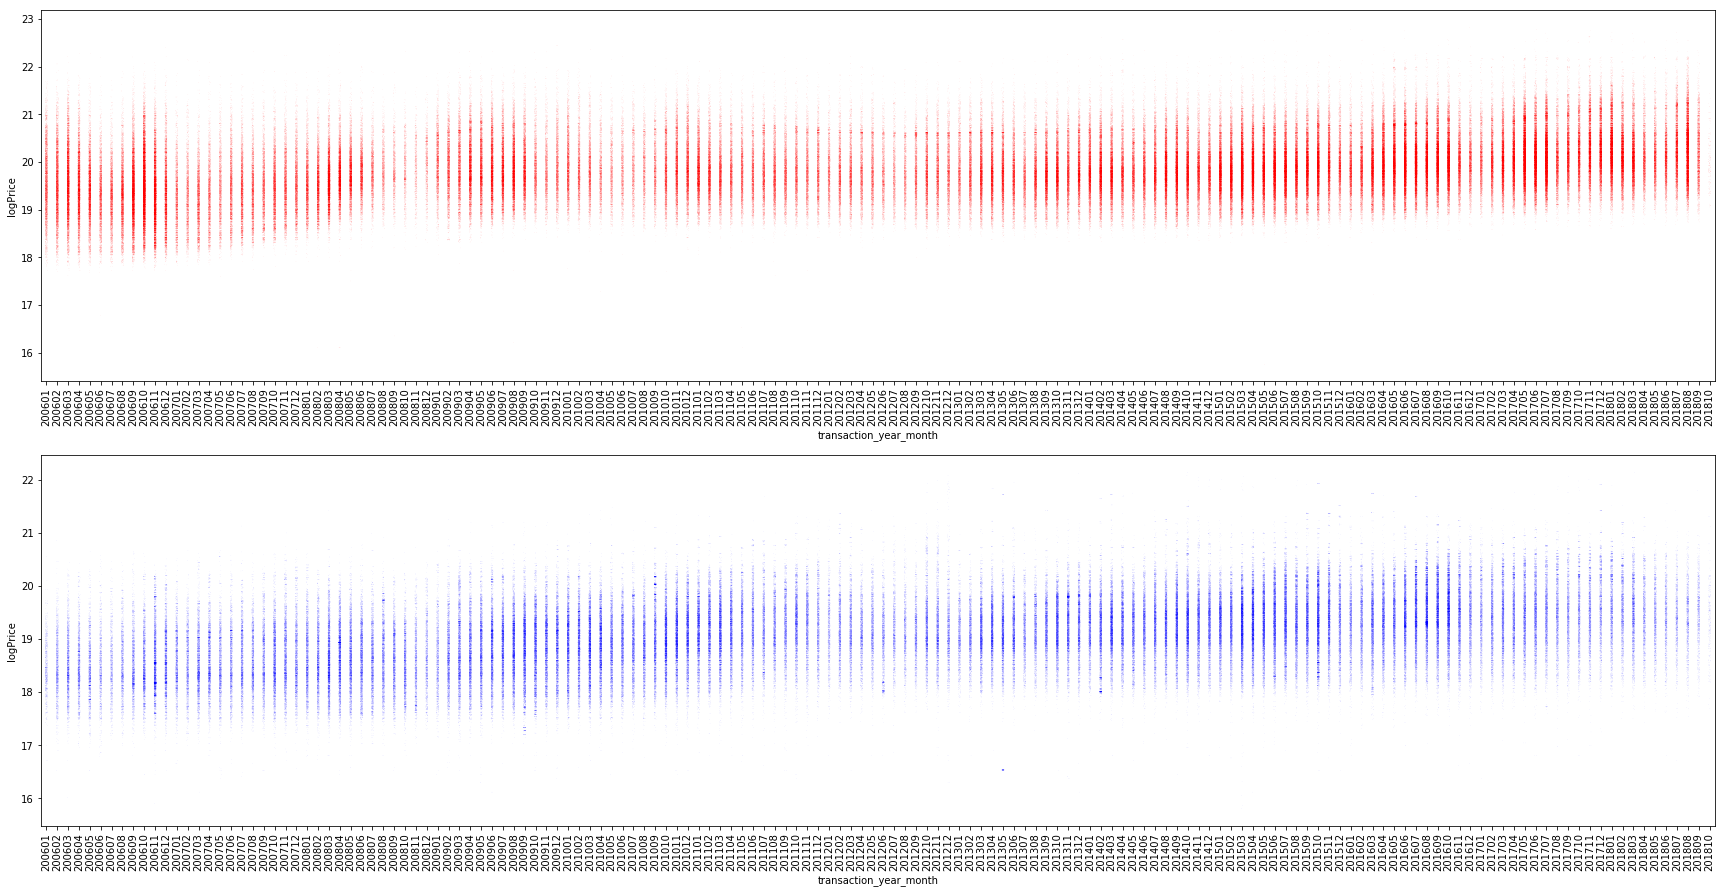

In [44]:
stripSB(col, seoulTrain, busanTrain)

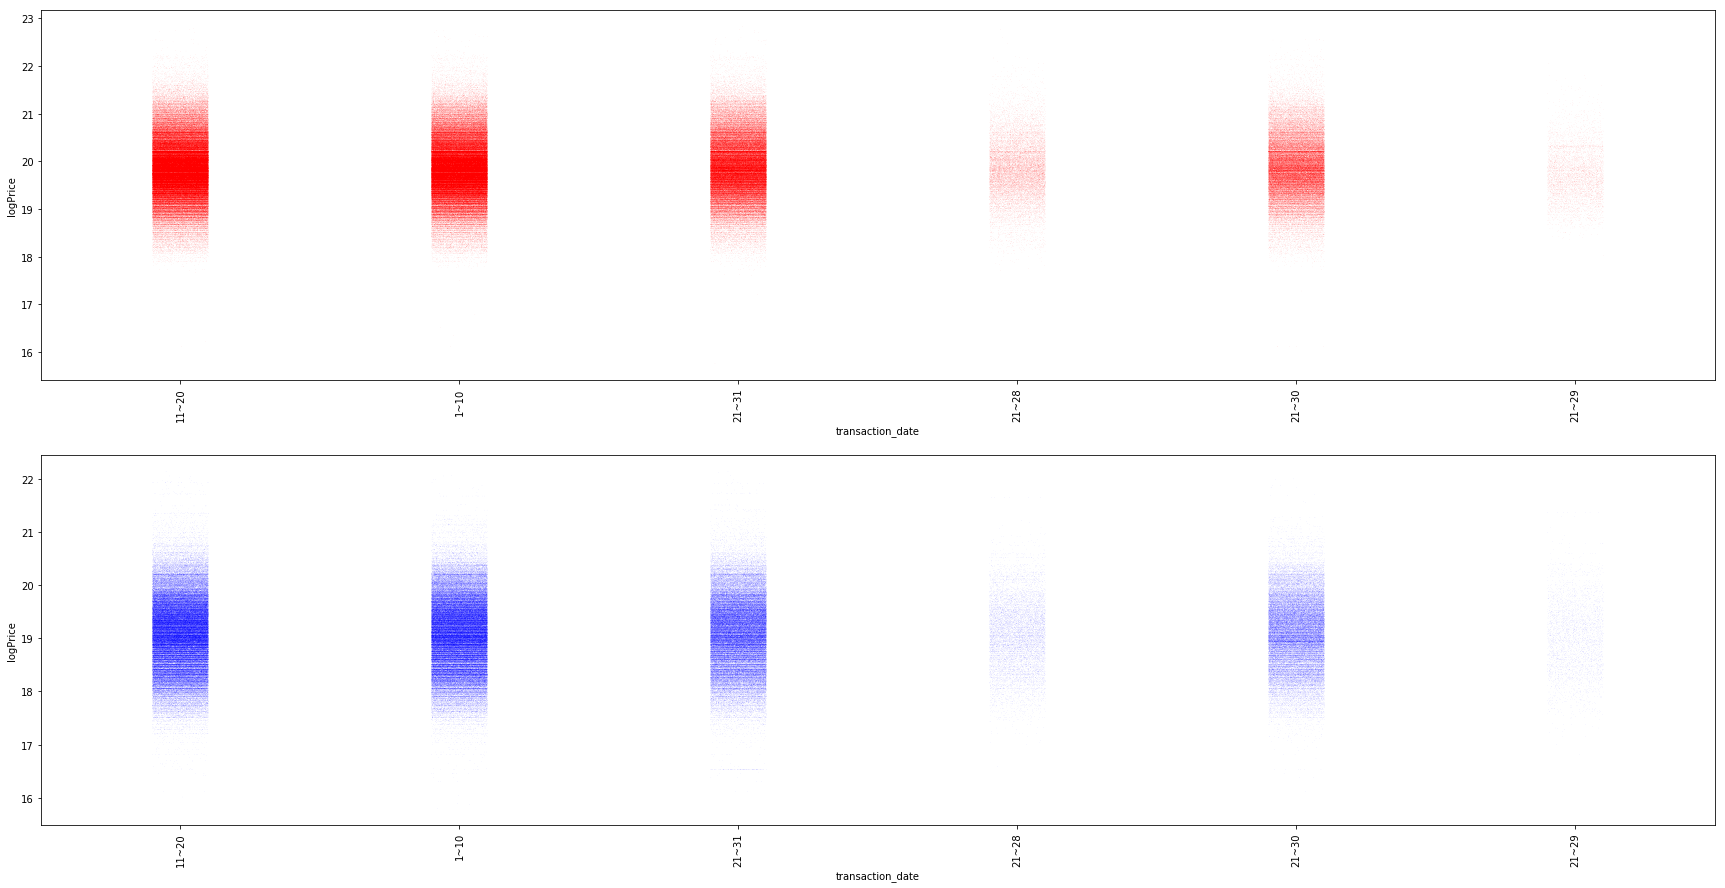

In [25]:
#거래일자
col = 'transaction_date'

# train.set_index("transaction_date")['logPrice'].plot(figsize=(30,8))
stripSB(col)

In [21]:
for df in (seoulTrain, busanTrain):
    print(df[col].unique())
# 말 일 날자를 합쳐야

['11~20' '1~10' '21~31' '21~28' '21~30' '21~29']
['11~20' '1~10' '21~31' '21~28' '21~30' '21~29']


In [72]:
col = 'year_of_completion'
colInfo(col)

int64
2005    89276
1999    80204
2003    80190
2004    76639
1996    73508
1998    70677
2001    70392
1988    69696
2008    69015
1993    66109
2000    63268
2006    63124
1997    63028
2002    58519
1992    54610
1995    52179
1994    43494
2007    42586
1989    35808
2011    31665
1991    31204
2009    29930
2010    28841
1986    28099
1987    26001
2012    22171
1990    19164
2014    18627
2013    18479
1985    14663
2015    14135
1983    14092
1984    12790
1982    11334
1978    10952
1979     9671
1980     9080
1981     8908
2016     4865
1977     3220
1976     2629
1971     2153
1974     2062
1975     2010
2017      996
1970      329
1973      291
1962      219
2018      202
1968      113
1972      100
1969       98
1966       43
Name: year_of_completion, dtype: int64
1999    200
2004    188
2005    182
2003    177
1998    164
1997    162
2000    150
1996    148
2006    145
1993    141
2002    132
2001    130
1995    130
1992    123
1994    114
2007    106
1988     98
2008     

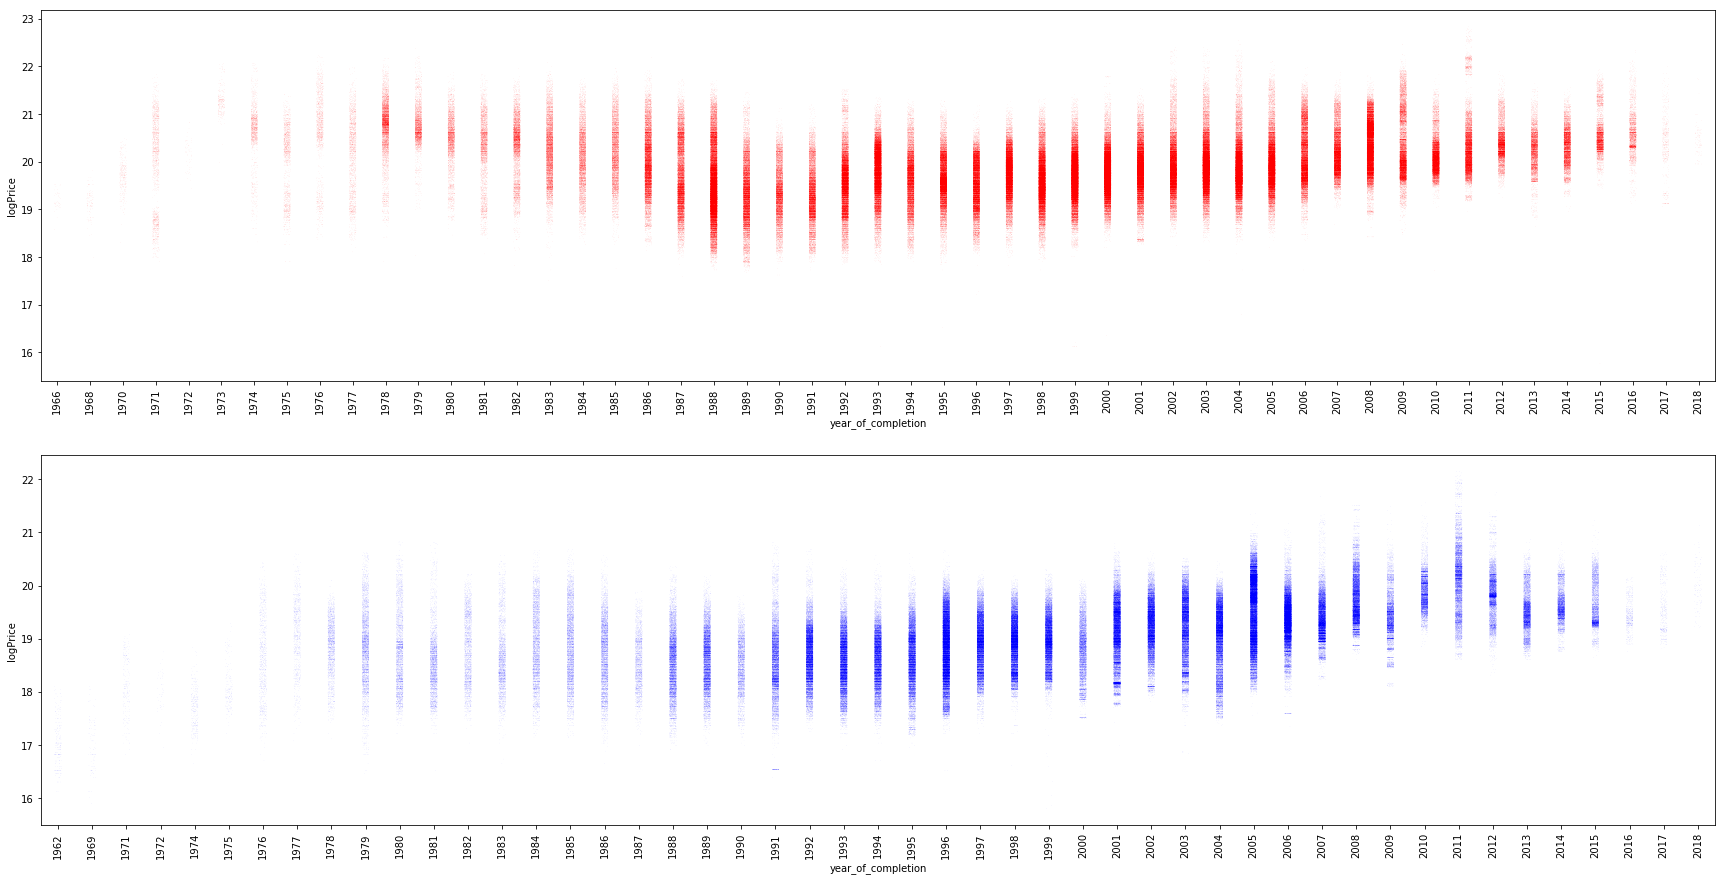

In [26]:
stripSB(col)

In [73]:
# 전용면적
col = 'exclusive_use_area'
colInfo(col)

float64
count    1.601458e+06
mean     7.946863e+01
std      2.800054e+01
min      1.639600e+01
25%      5.984000e+01
50%      8.446000e+01
75%      8.498000e+01
max      2.954340e+02
Name: exclusive_use_area, dtype: float64
count    3918.000000
mean       82.191308
std        28.127419
min        16.536000
25%        59.940000
50%        84.600000
75%        84.980000
max       257.260000
Name: exclusive_use_area, dtype: float64
train na :  0
test na : 0


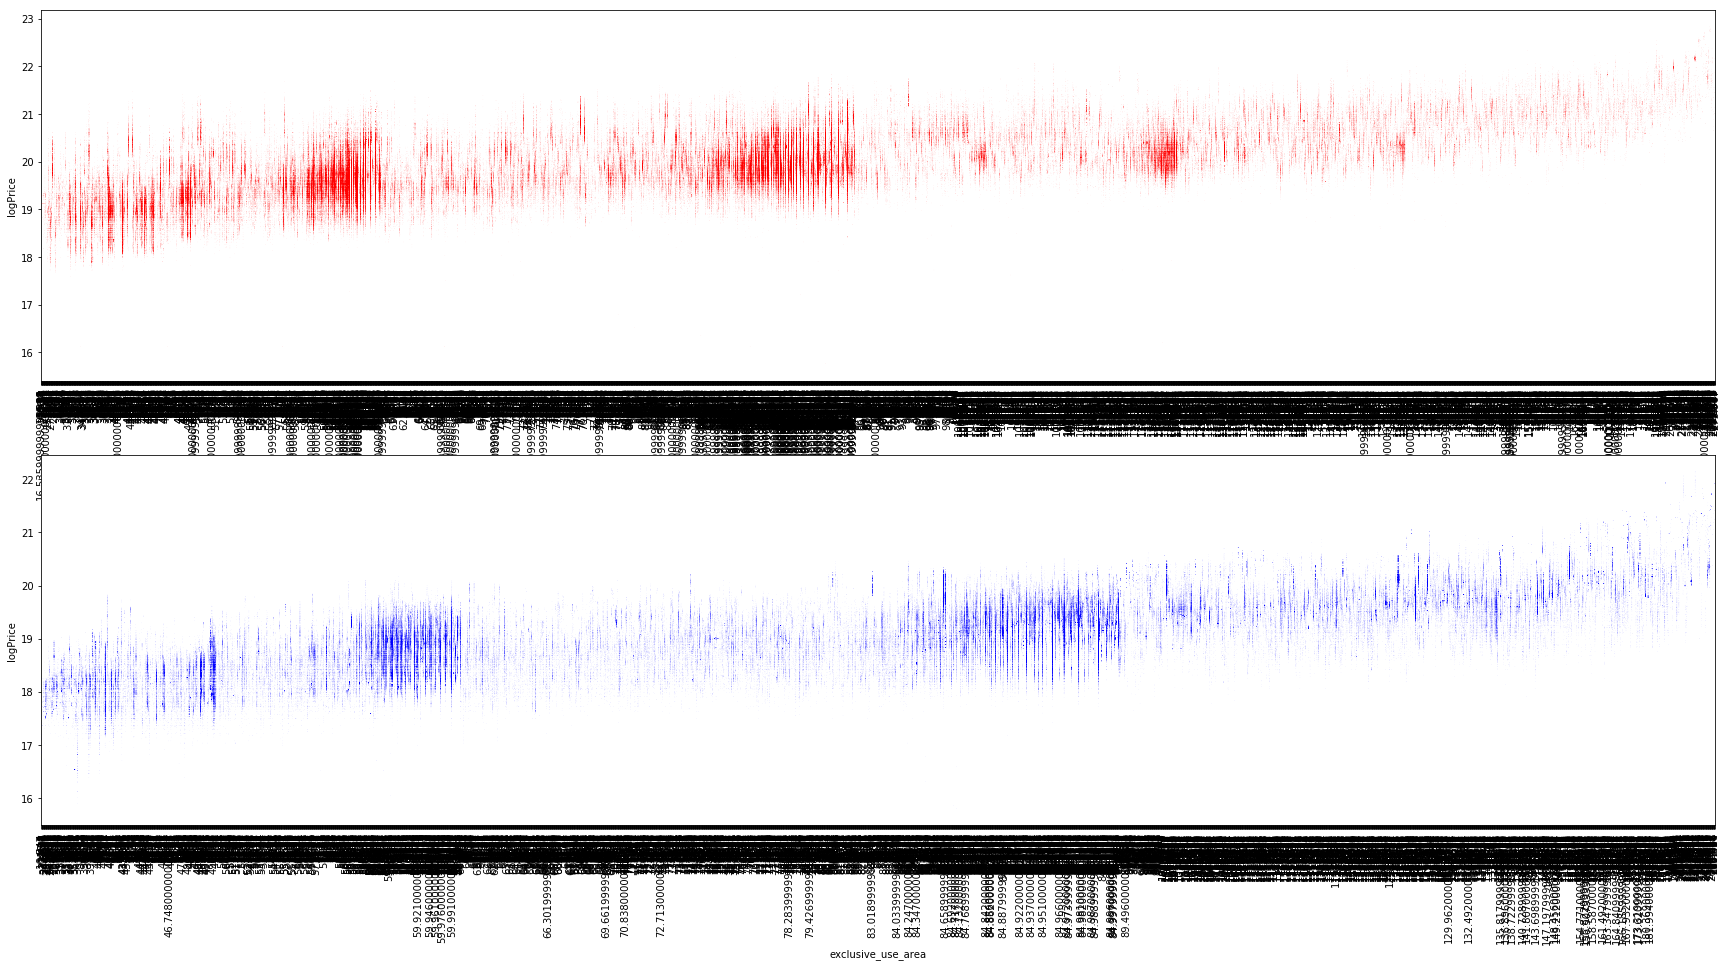

In [30]:
stripSB(col)
## 전용면적과 가격은 거의 직선관계 : but 분산이 크다.

In [76]:
''' 층
discrete
층이 높을수록 비교적 비쌈
층이 높을수록 분산이 적어짐 : 비교적 낮은 가격에 거래되는 경우가 적어짐
    - 이는 단순히 '고층 건물'이 비싸다고 생각할 수도 있음
'''
col = 'floor'
colInfo(col)

int64
 4     101137
 5     100732
 3      99167
 2      96003
 1      92461
 6      90908
 7      88293
 8      87443
 9      87341
 10     85446
 11     82390
 12     80072
 13     73401
 14     70057
 15     65869
 16     40481
 17     39080
 18     36144
 19     32416
 20     28640
 21     21573
 22     18812
 23     16576
 24     13693
 25     11117
 26      4889
 27      4693
 28      3807
 29      3257
 30      2702
        ...  
 57       122
 55       110
 60       107
 54        92
 65        79
 56        77
 66        65
 59        64
-1         53
 61        52
 62        51
 67        39
 72        38
 68        37
 70        36
 64        33
 63        29
-2         28
 71        24
 69        21
-3         15
 74        11
 73         9
 75         9
-4          8
 77         5
 78         4
 80         4
 76         3
 79         2
Name: floor, Length: 84, dtype: int64
 3     306
 5     291
 4     283
 2     279
 1     257
 7     250
 11    223
 8     212
 6     211
 10

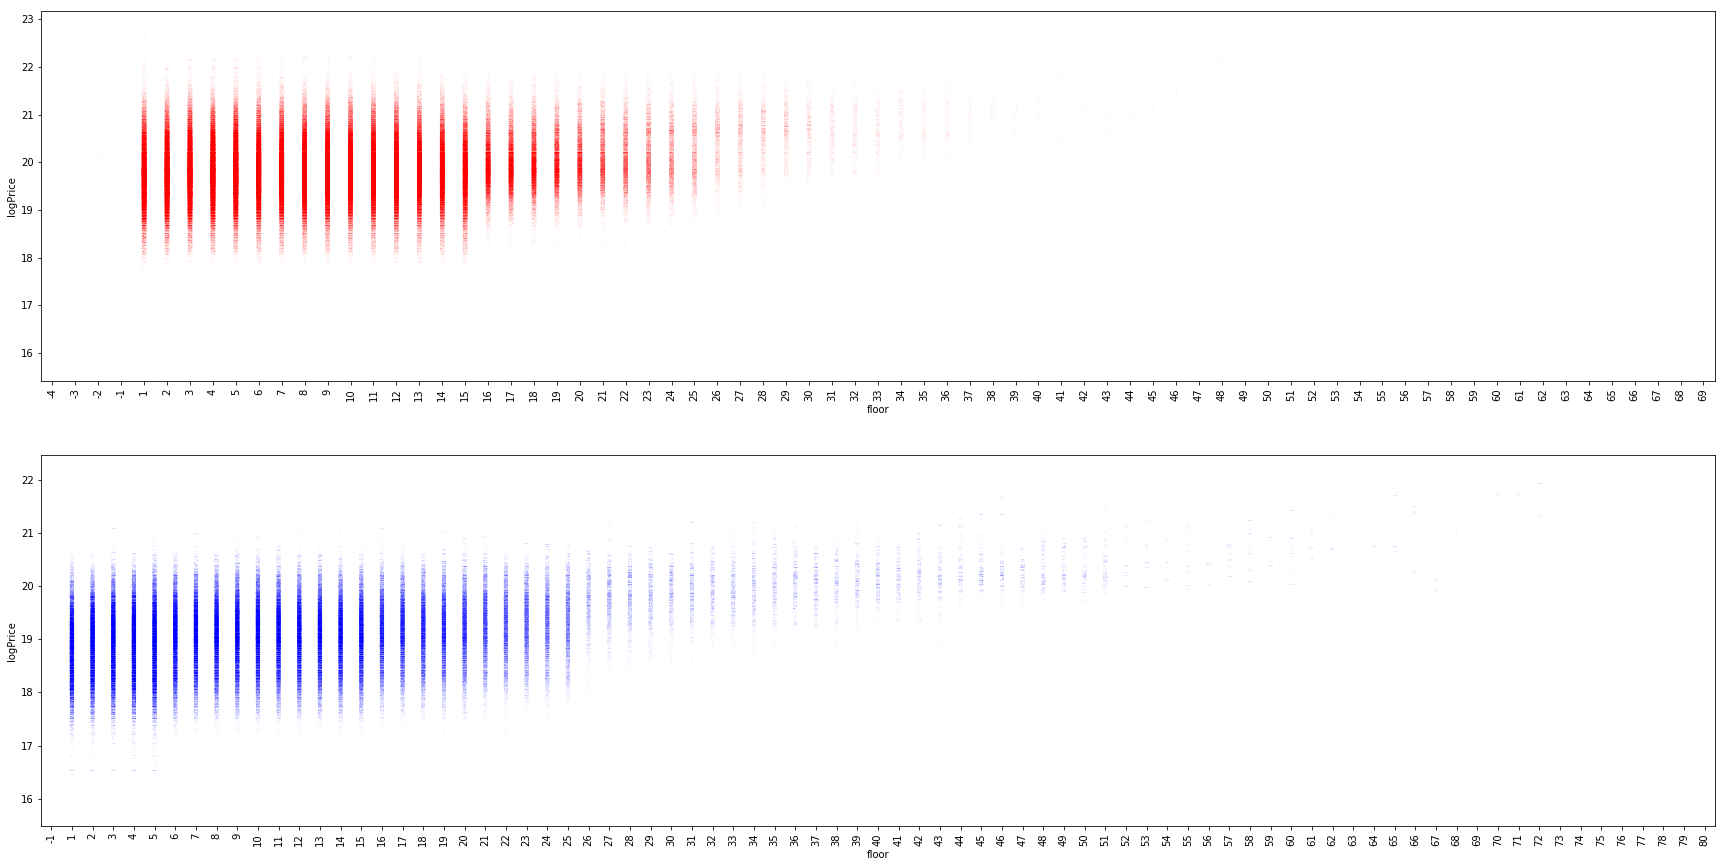

In [10]:
stripSB(col, seoulTrain, busanTrain)

In [74]:
'''단지내 총 주차대수
NaN
continuous
애매하지만 주차대수가 많을수록 가격이 증가하는 편
'''
col ='total_parking_capacity_in_site'
colInfo(col)

float64
count    1.509645e+06
mean     1.350190e+03
std      1.494473e+03
min      0.000000e+00
25%      4.130000e+02
50%      8.200000e+02
75%      1.659000e+03
max      9.766000e+03
Name: total_parking_capacity_in_site, dtype: float64
count    3547.000000
mean      588.145475
std       710.959963
min         0.000000
25%       196.000000
50%       354.000000
75%       693.000000
max      9766.000000
Name: total_parking_capacity_in_site, dtype: float64
train na :  91813
test na : 371


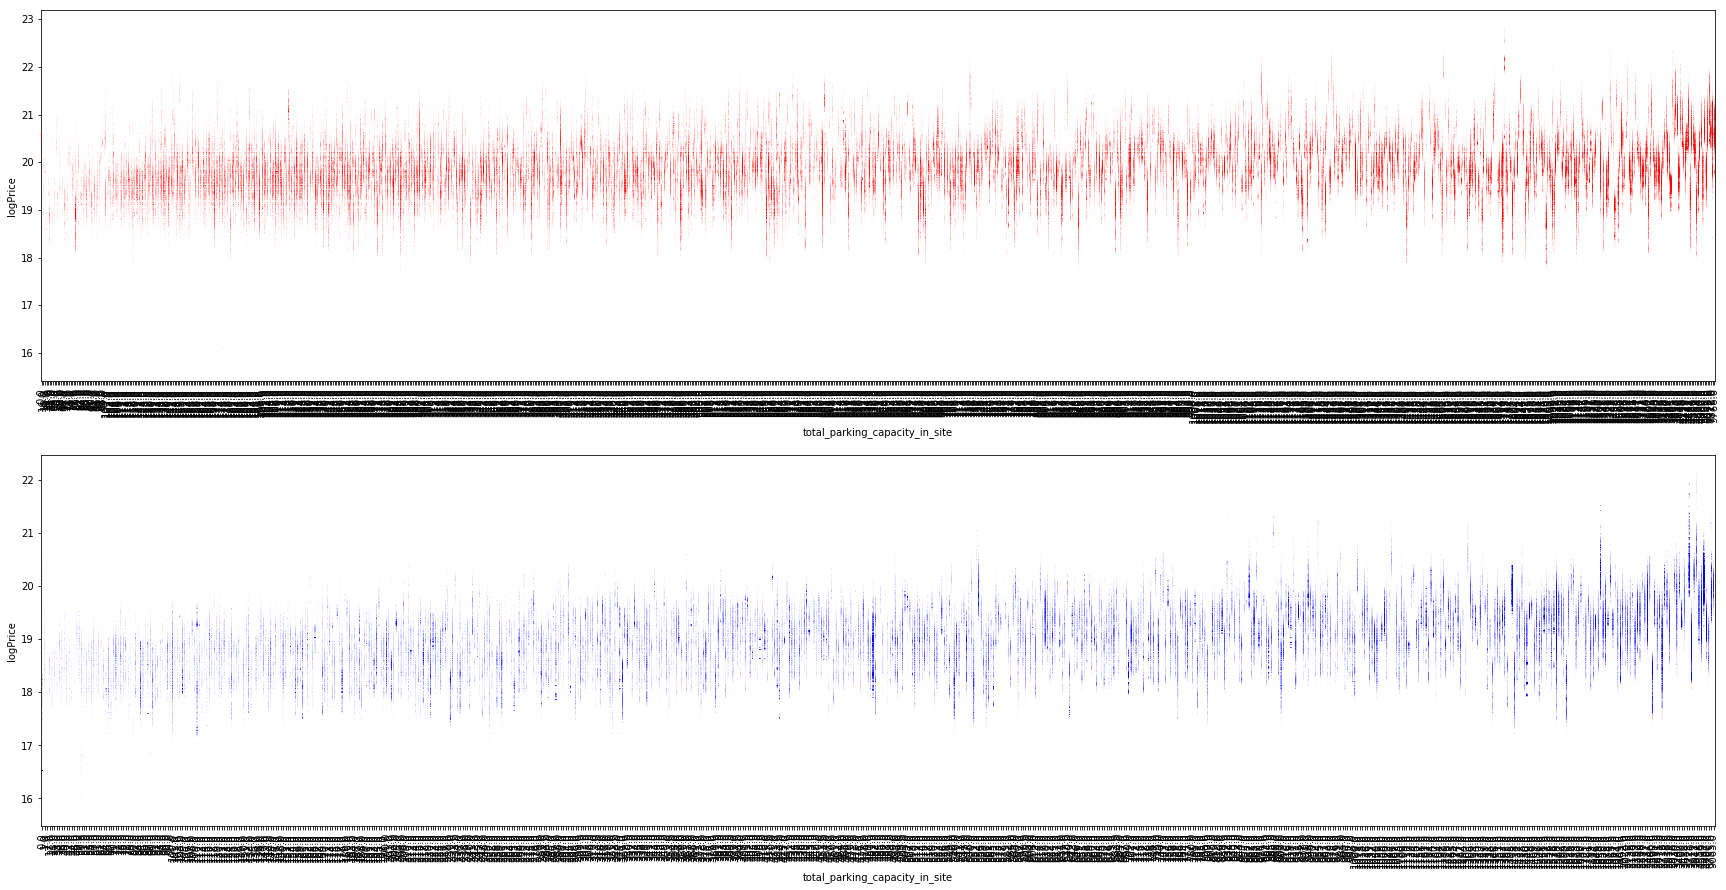

In [15]:
for df in (seoulTrain, busanTrain):
    df[col].fillna(0)
stripSB(col, seoulTrain, busanTrain)

In [75]:
''' 단지 내 총 세대수
discrete
육안으로는 특징 없음
'''
col = 'total_household_count_in_sites'
colInfo(col)

int64
count    1.601458e+06
mean     1.181628e+03
std      1.128092e+03
min      9.900000e+01
25%      4.160000e+02
50%      8.110000e+02
75%      1.590000e+03
max      6.864000e+03
Name: total_household_count_in_sites, dtype: float64
count    3918.000000
mean      510.825676
std       575.971467
min        99.000000
25%       180.000000
50%       305.000000
75%       603.000000
max      6864.000000
Name: total_household_count_in_sites, dtype: float64
train na :  0
test na : 0


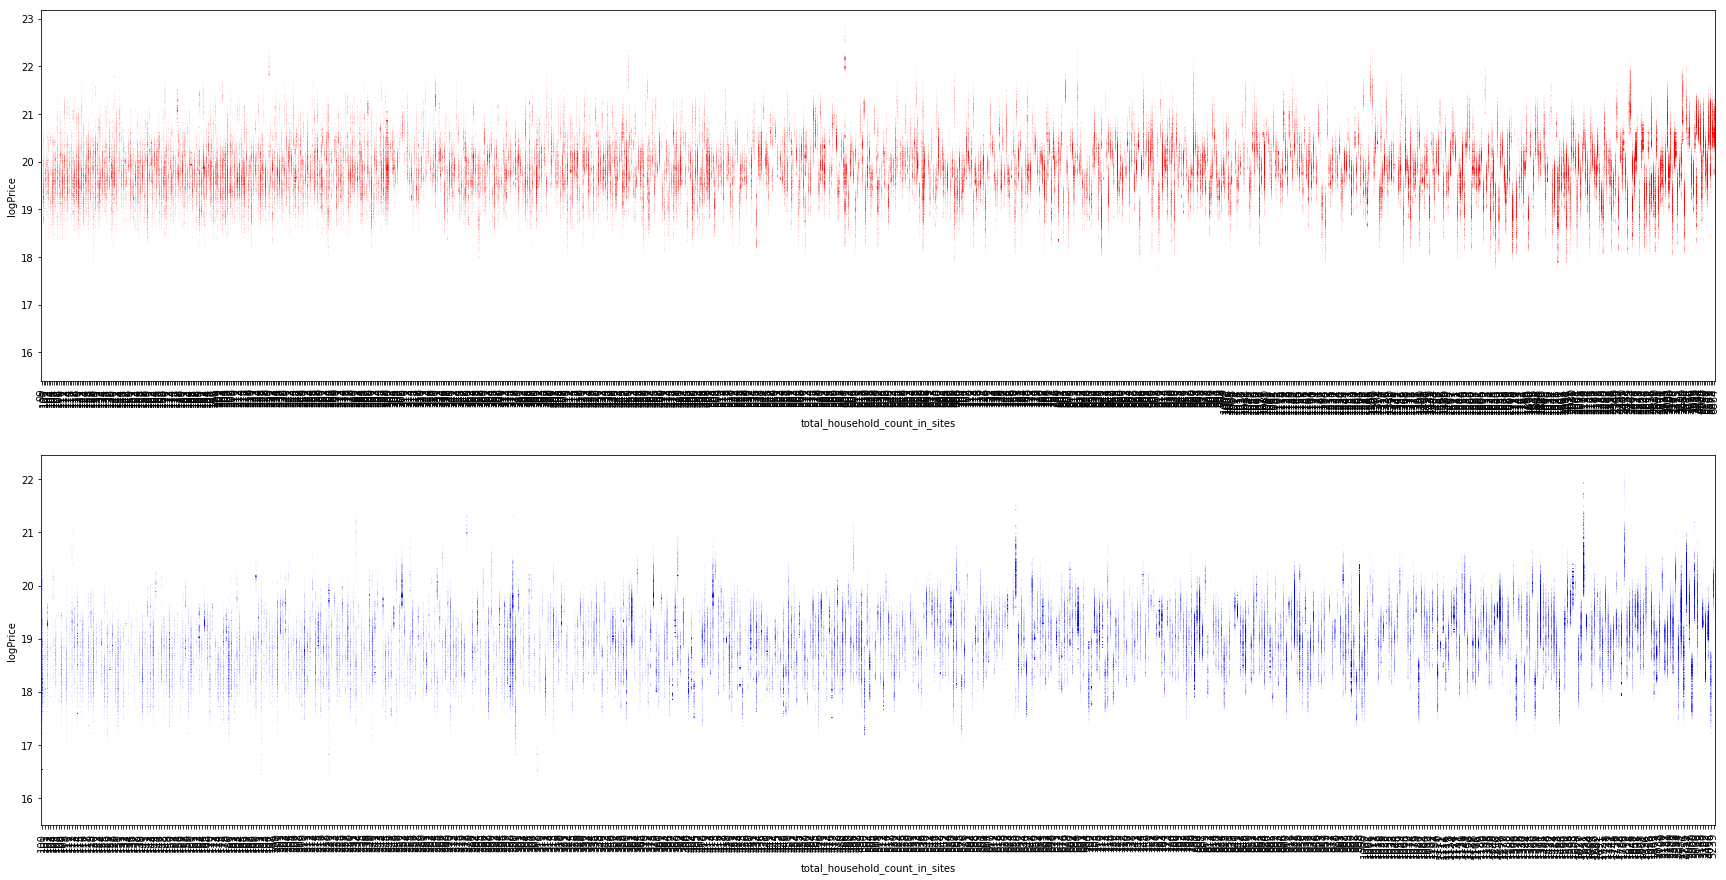

In [17]:
stripSB(col, seoulTrain, busanTrain)

In [77]:
'''단지 내 총 동수
discrete
총 동수 자체가 영향을 미친다기 보다는, 아마 단지별 가격대로 찍히는 듯
    - 특히 동수가 많은 쪽에서
'''
col = 'apartment_building_count_in_sites'
colInfo(col)

int64
3      118685
2      115658
6      107772
4      102692
1       88459
5       86553
9       83478
7       77896
8       77823
10      69228
14      61320
11      58438
15      58377
16      50143
12      47922
13      45414
18      29591
25      27329
17      25277
21      21559
30      19160
19      17250
65      17000
24      16182
26      13996
28      13105
22      11352
20      11326
23      11247
49      10302
35       9929
32       9894
34       9447
31       8777
42       7644
33       6859
29       6406
40       5500
66       4236
51       4032
27       3995
54       3629
124      3428
37       3292
122      2764
72       2451
44       2390
56       2239
46       1801
58       1615
48       1598
50       1278
36       1201
99       1160
47        950
41        409
Name: apartment_building_count_in_sites, dtype: int64
2      691
1      614
3      533
4      396
5      276
6      245
7      173
8      159
9      131
10     101
11      91
13      69
12      68
15      54
14

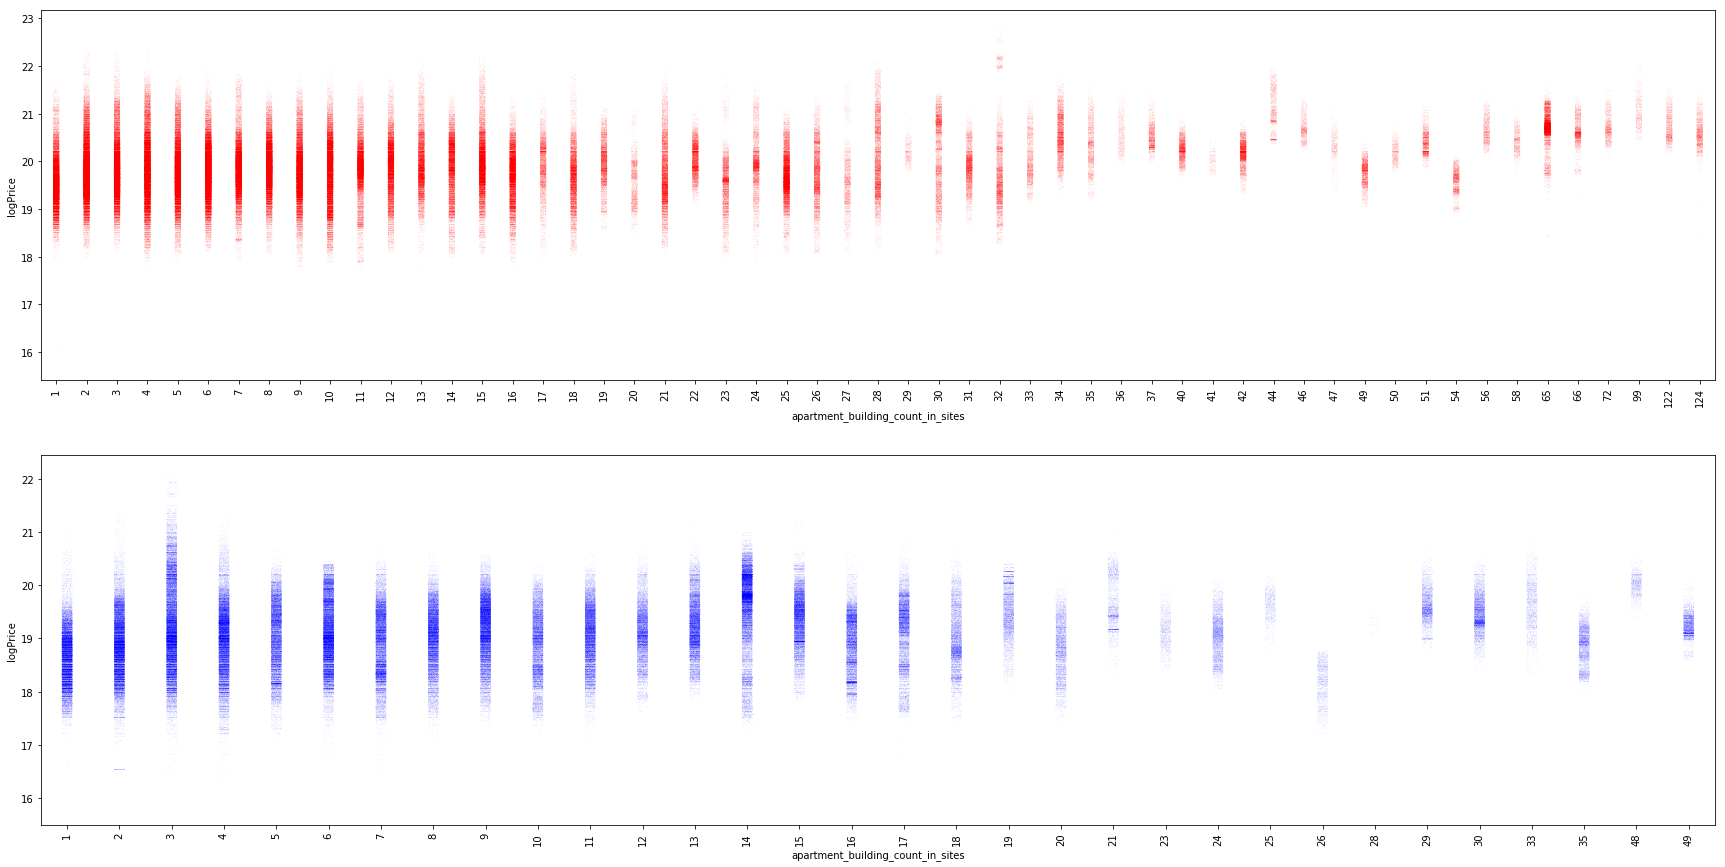

In [20]:
stripSB(col, seoulTrain, busanTrain)

In [78]:
'''단지 내 최고층
단지 종속적이지 않나..
discrete 아마 nan 있을 듯
'''
col ='tallest_building_in_sites'
colInfo(col)

float64
count    1.601449e+06
mean     2.077357e+01
std      8.750388e+00
min      5.000000e+00
25%      1.500000e+01
50%      2.000000e+01
75%      2.500000e+01
max      8.000000e+01
Name: tallest_building_in_sites, dtype: float64
count    3917.000000
mean       18.296145
std         7.497573
min         5.000000
25%        15.000000
50%        17.000000
75%        23.000000
max        80.000000
Name: tallest_building_in_sites, dtype: float64
train na :  9
test na : 1


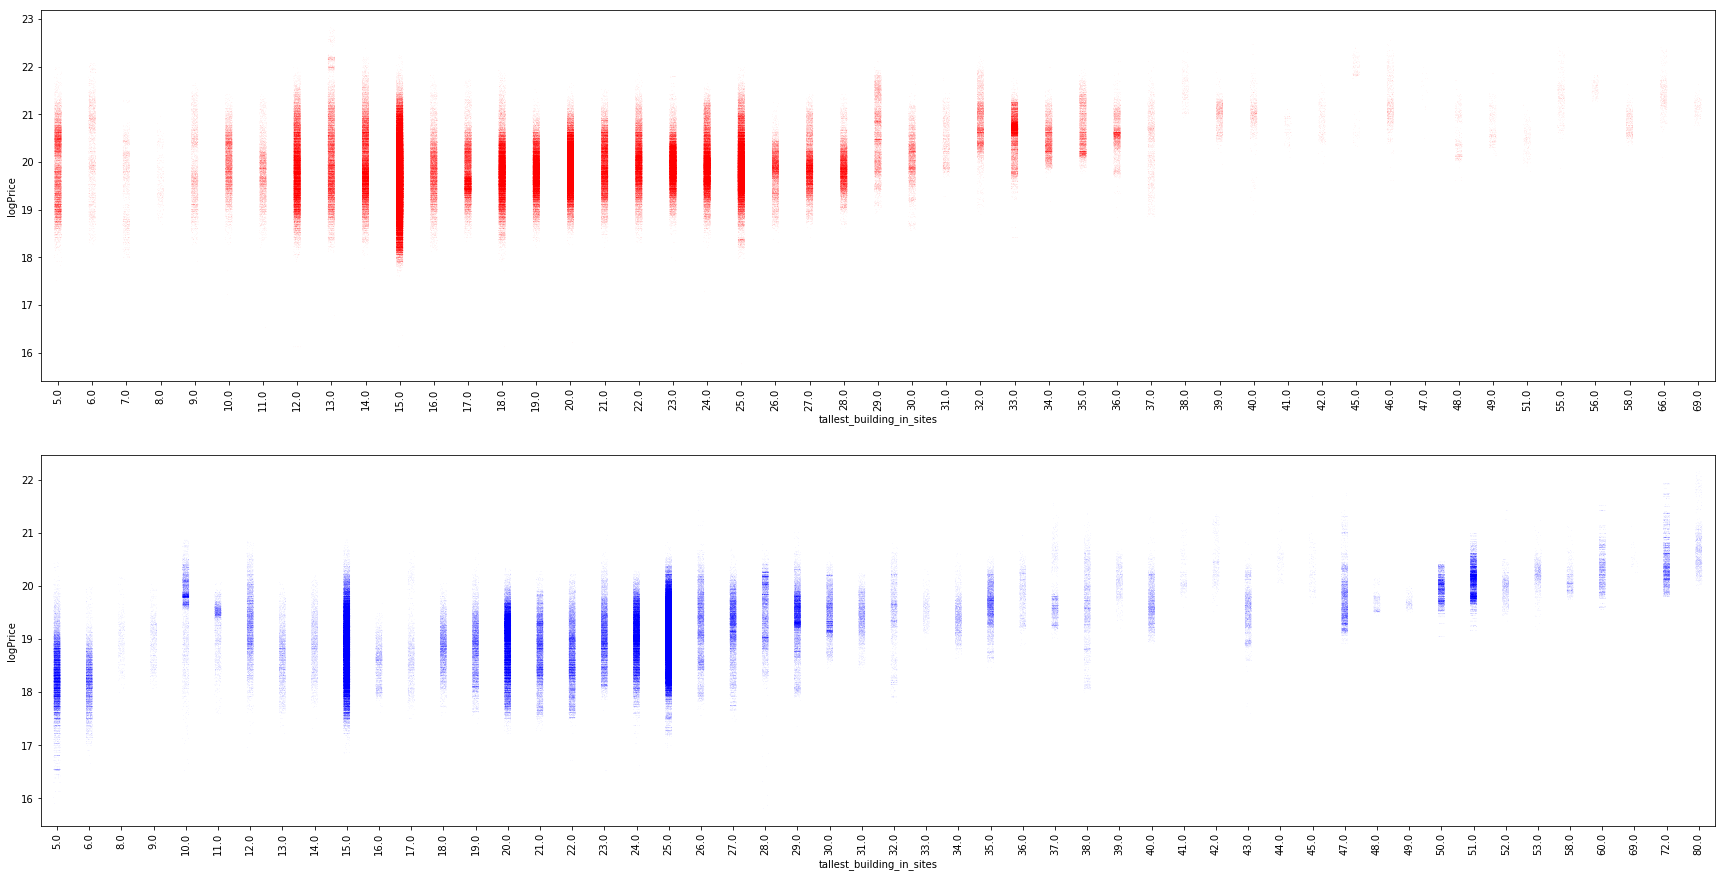

In [23]:
stripSB(col, seoulTrain, busanTrain)

In [80]:
''' 면적
'''
col = 'supply_area'
colInfo(col)

float64
count    1.601458e+06
mean     1.020035e+02
std      3.306049e+01
min      2.010000e+01
25%      7.993000e+01
50%      1.029600e+02
75%      1.115400e+02
max      4.234000e+02
Name: supply_area, dtype: float64
count    3918.00000
mean      104.43292
std        32.98825
min        25.12000
25%        81.79000
50%       103.92000
75%       112.42500
max       324.01000
Name: supply_area, dtype: float64
train na :  0
test na : 0


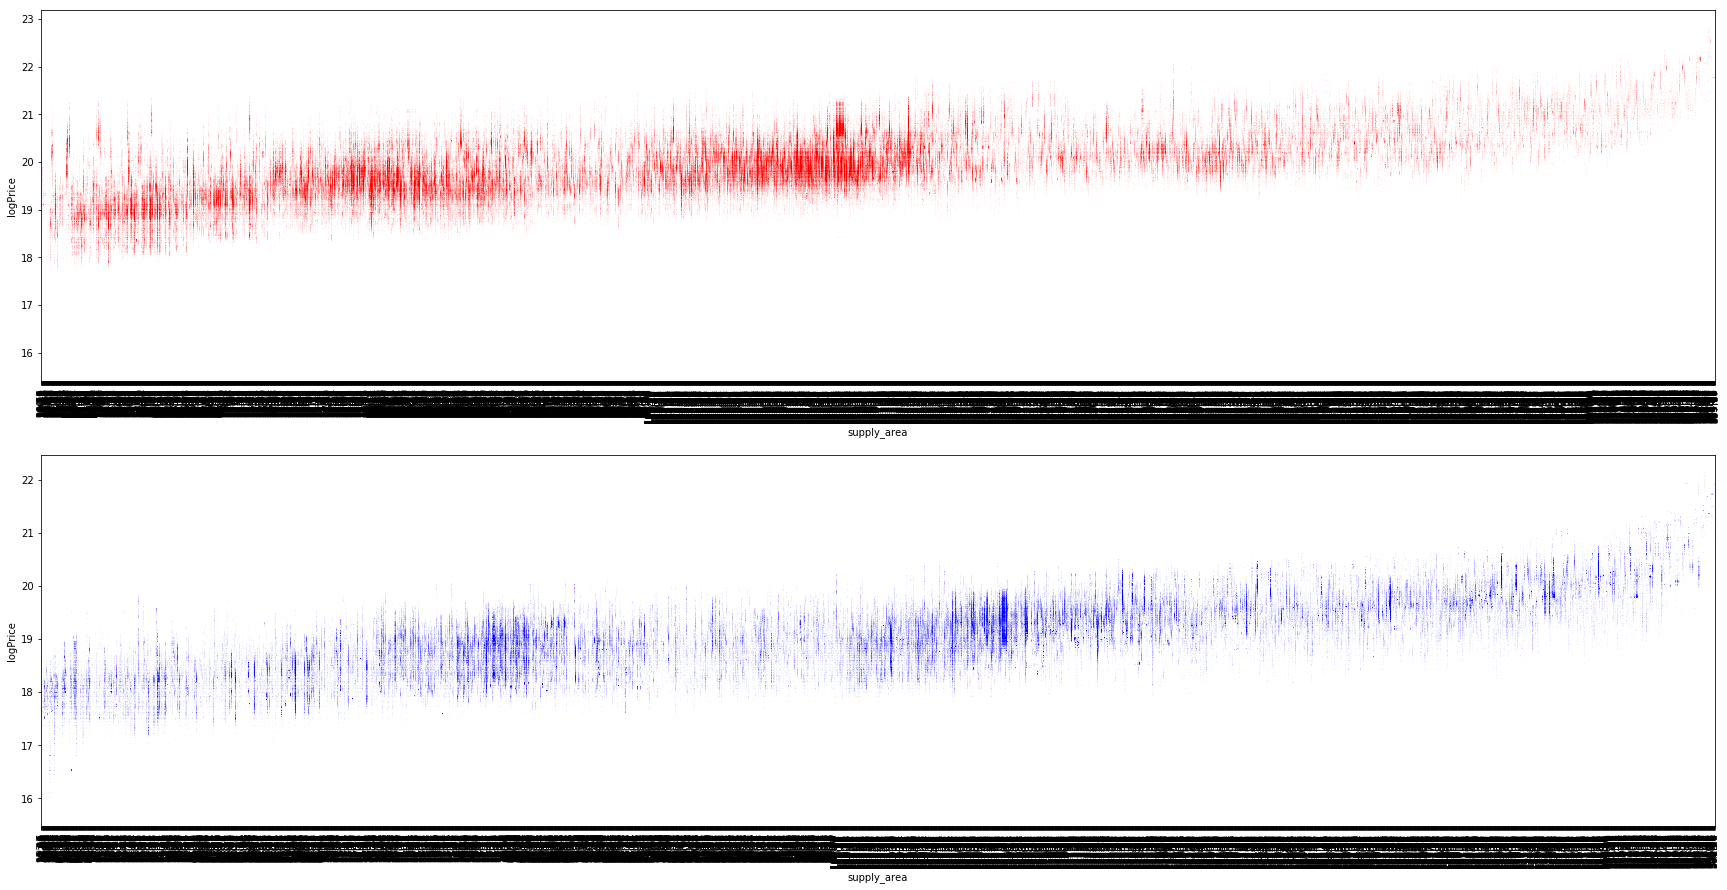

In [81]:
stripSB(col, seoulTrain, busanTrain)

In [82]:
''' 평형의 총 세대수
'''
col = 'total_household_count_of_area_type'
colInfo(col)

int64
count    1.601458e+06
mean     2.931756e+02
std      3.237872e+02
min      0.000000e+00
25%      9.000000e+01
50%      1.940000e+02
75%      3.840000e+02
max      2.960000e+03
Name: total_household_count_of_area_type, dtype: float64
count    3918.000000
mean      155.846350
std       182.491791
min         0.000000
25%        48.000000
50%        98.000000
75%       193.000000
max      2960.000000
Name: total_household_count_of_area_type, dtype: float64
train na :  0
test na : 0


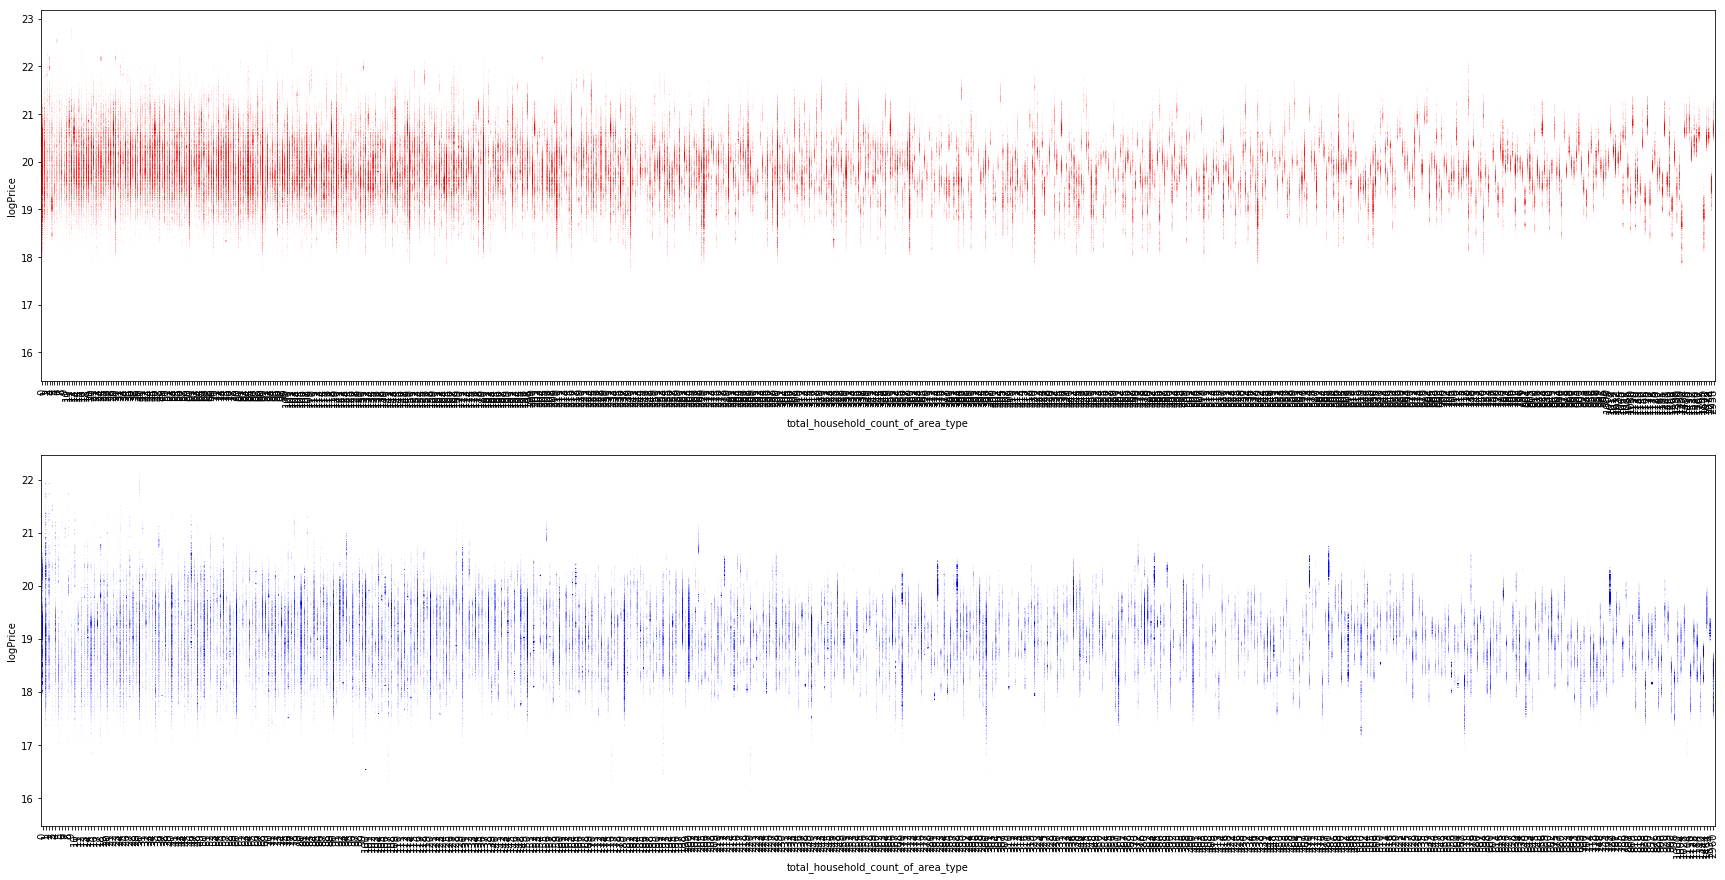

In [7]:
stripSB(col, seoulTrain, busanTrain)

In [83]:
'''단지 내 최저층 동의 수?
'''
col = 'lowest_building_in_sites'
colInfo(col)

float64
count    1.601449e+06
mean     1.393617e+01
std      6.785973e+00
min      1.000000e+00
25%      9.000000e+00
50%      1.300000e+01
75%      1.700000e+01
max      7.000000e+01
Name: lowest_building_in_sites, dtype: float64
count    3917.000000
mean       12.827164
std         6.705995
min         1.000000
25%         8.000000
50%        12.000000
75%        16.000000
max        70.000000
Name: lowest_building_in_sites, dtype: float64
train na :  9
test na : 1


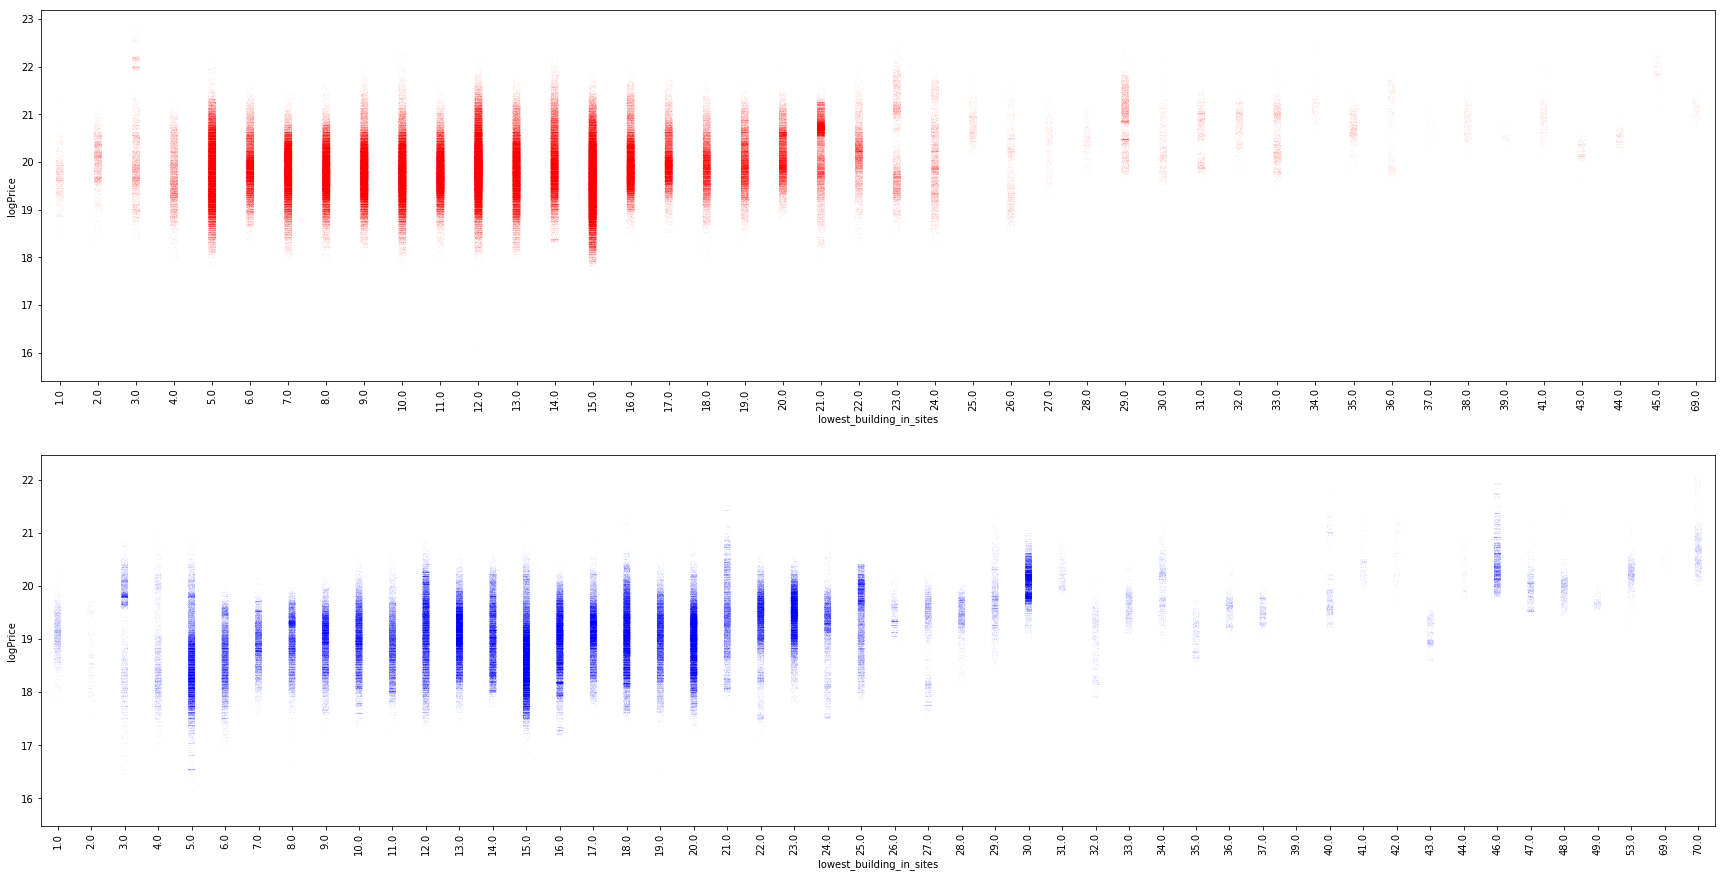

In [10]:
stripSB(col, seoulTrain, busanTrain)

In [84]:
'''
방수
Null : 같은 전용면적과 비교해서
'''
col = 'room_count'
colInfo(col)

float64
count    1.600767e+06
mean     2.951266e+00
std      6.653449e-01
min      0.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      3.000000e+00
max      8.000000e+00
Name: room_count, dtype: float64
count    3913.000000
mean        3.009200
std         0.647804
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: room_count, dtype: float64
train na :  691
test na : 5


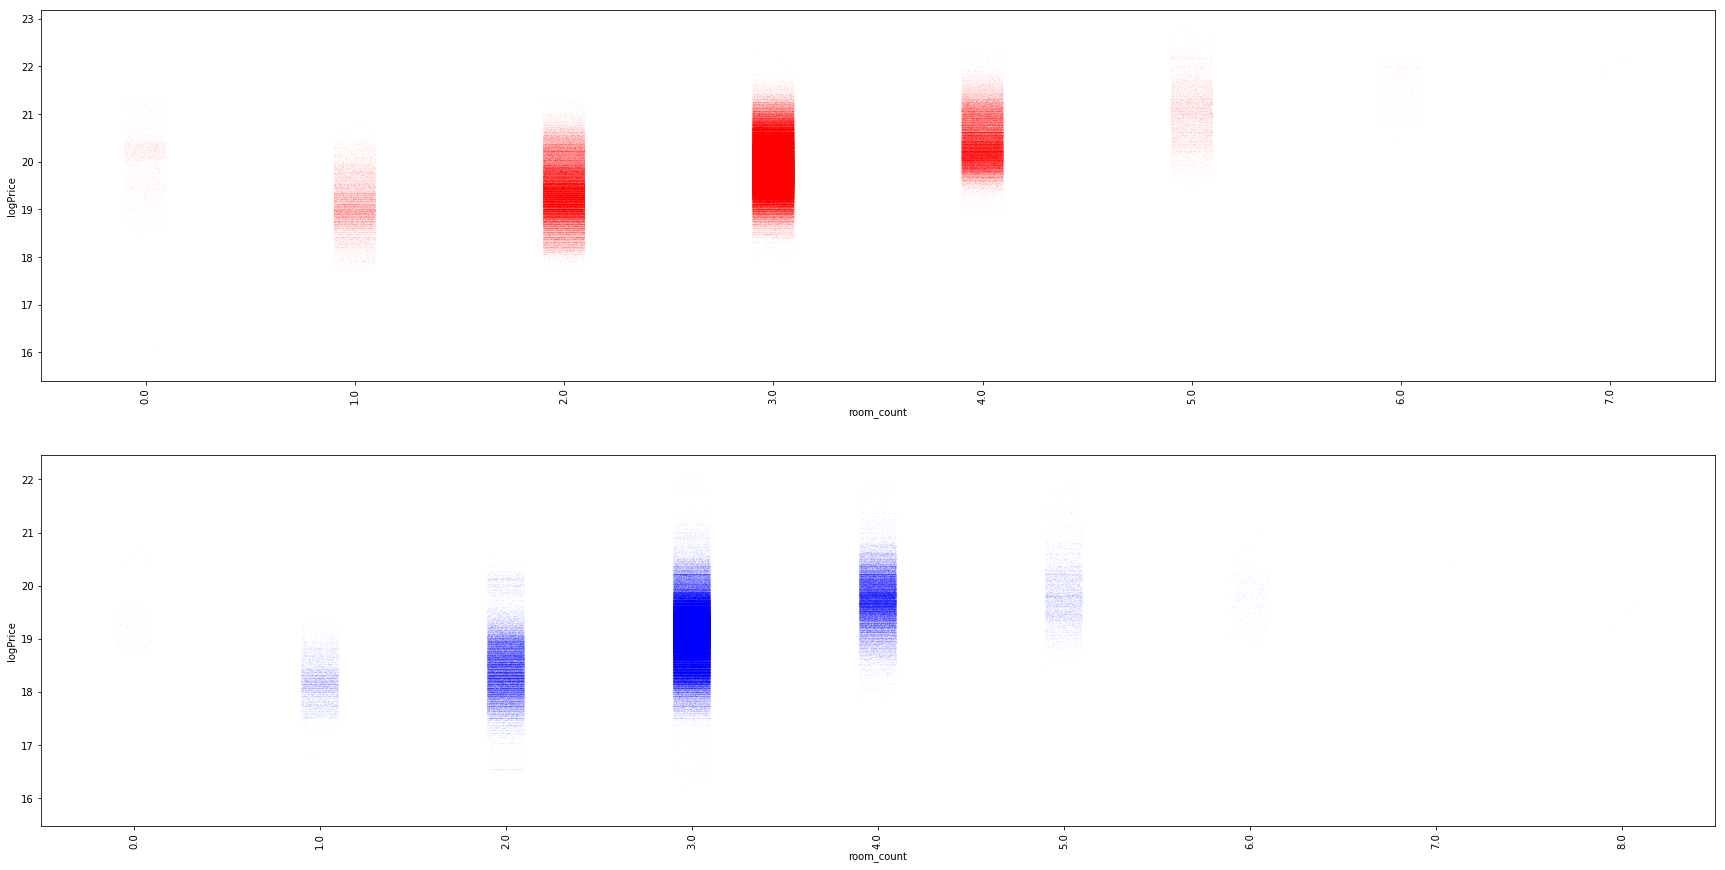

In [12]:
stripSB(col, seoulTrain, busanTrain)

In [85]:
'''
화장실 수
Null : 같은 전용면적 대비, 일단 1~2개
'''
col = 'bathroom_count'
colInfo(col)

float64
count    1.600767e+06
mean     1.587173e+00
std      5.071750e-01
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      5.000000e+00
Name: bathroom_count, dtype: float64
count    3913.000000
mean        1.641963
std         0.501885
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: bathroom_count, dtype: float64
train na :  691
test na : 5


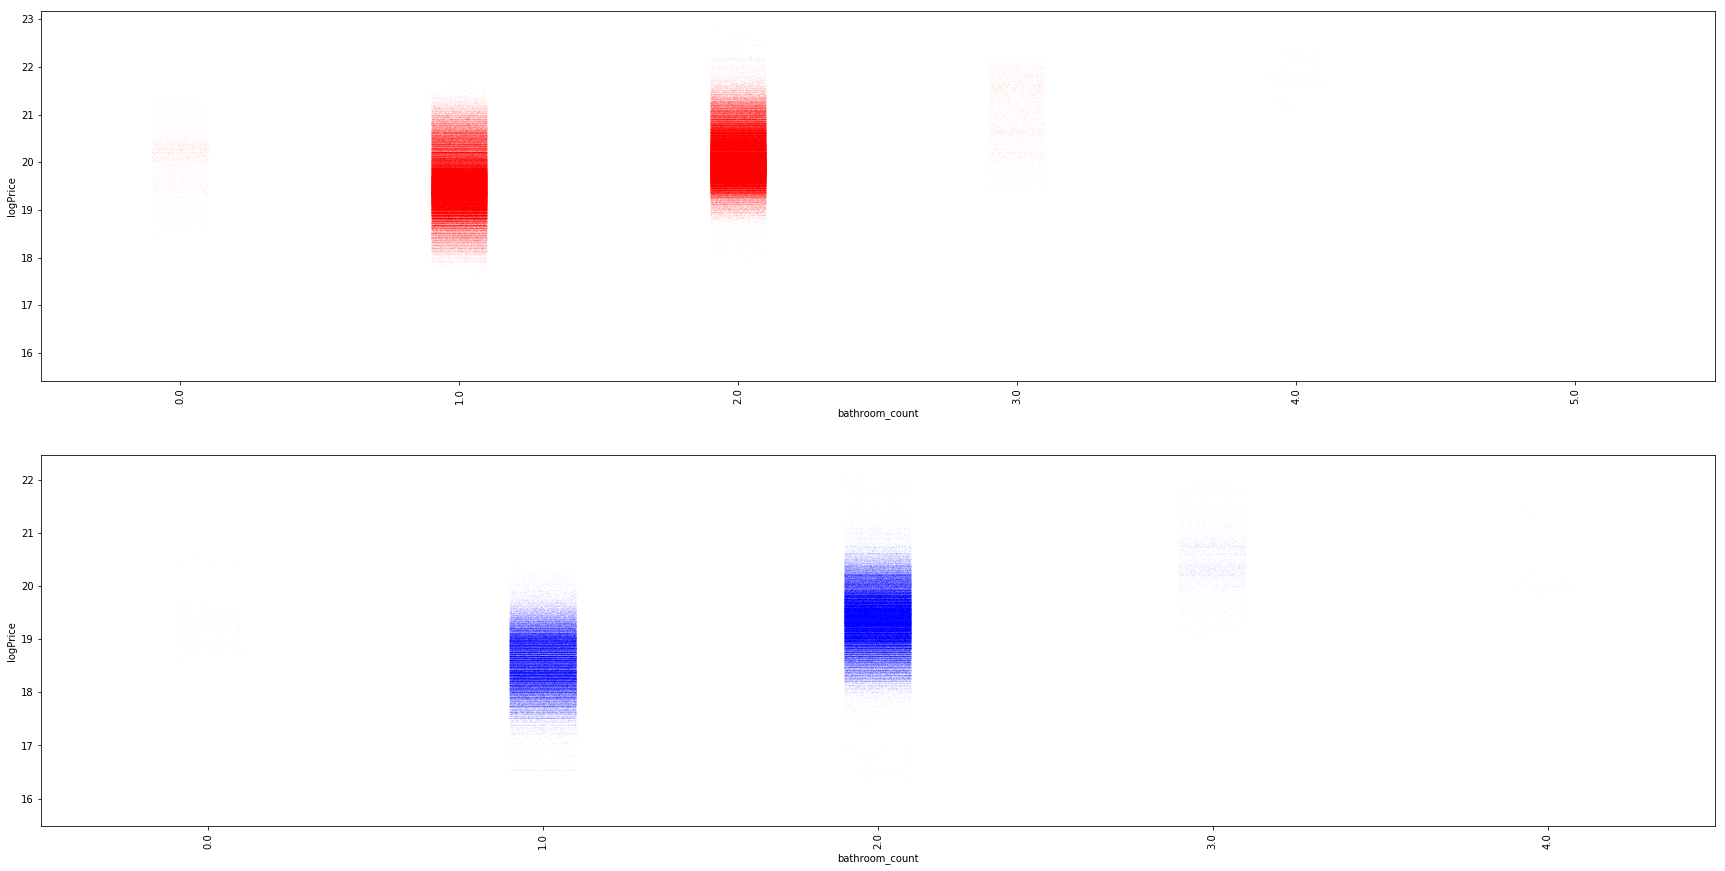

In [21]:
stripSB(col, seoulTrain, busanTrain)

In [86]:
'''
난방 연료 : 가스 vs 열병합
Null : 열병합은 지역에 관련 있으니까 지역 정보를 보는 건 어떨까
        차라리 새로운 카테고리로 처리?
        가격과 비교했을 때 기본적으로 가스와 비슷하다.
        열병합은 가격이 조금 비쌈
'''
col = 'heat_fuel'
colInfo(col)

object
gas             1204679
cogeneration     378141
NaN                9667
-                  8971
Name: heat_fuel, dtype: int64
gas             3152
cogeneration     671
NaN               48
-                 47
Name: heat_fuel, dtype: int64
train na :  9667
test na : 48


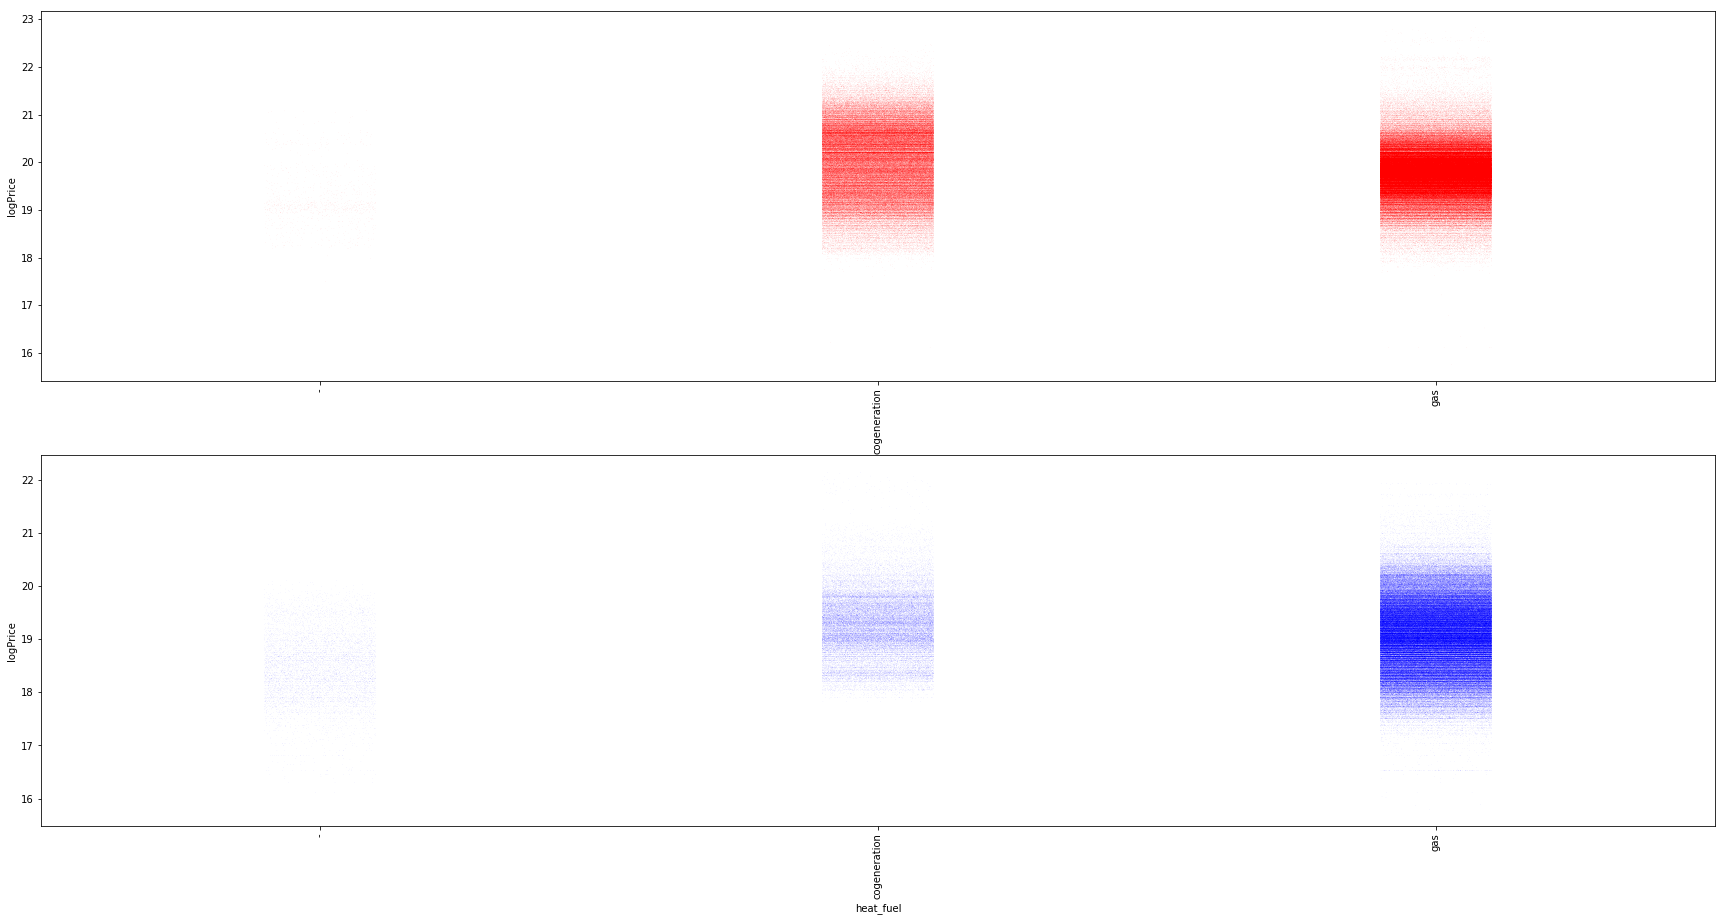

In [24]:
stripSB(col, seoulTrain, busanTrain)

In [87]:
'''
난방방식
Null : 알 수 없음
        알 수 없는 null들은 차라리 null col을 빼고 계산한 데이터 중 특성이 비슷한 걸 이용해서 처리할 수 있지 않을까
        난방방식을 학습하기..??
'''
col = 'heat_type'
colInfo(col)

object
individual    1085870
district       379822
central        133749
NaN              2017
Name: heat_type, dtype: int64
individual    3013
district       673
central        204
NaN             28
Name: heat_type, dtype: int64
train na :  2017
test na : 28


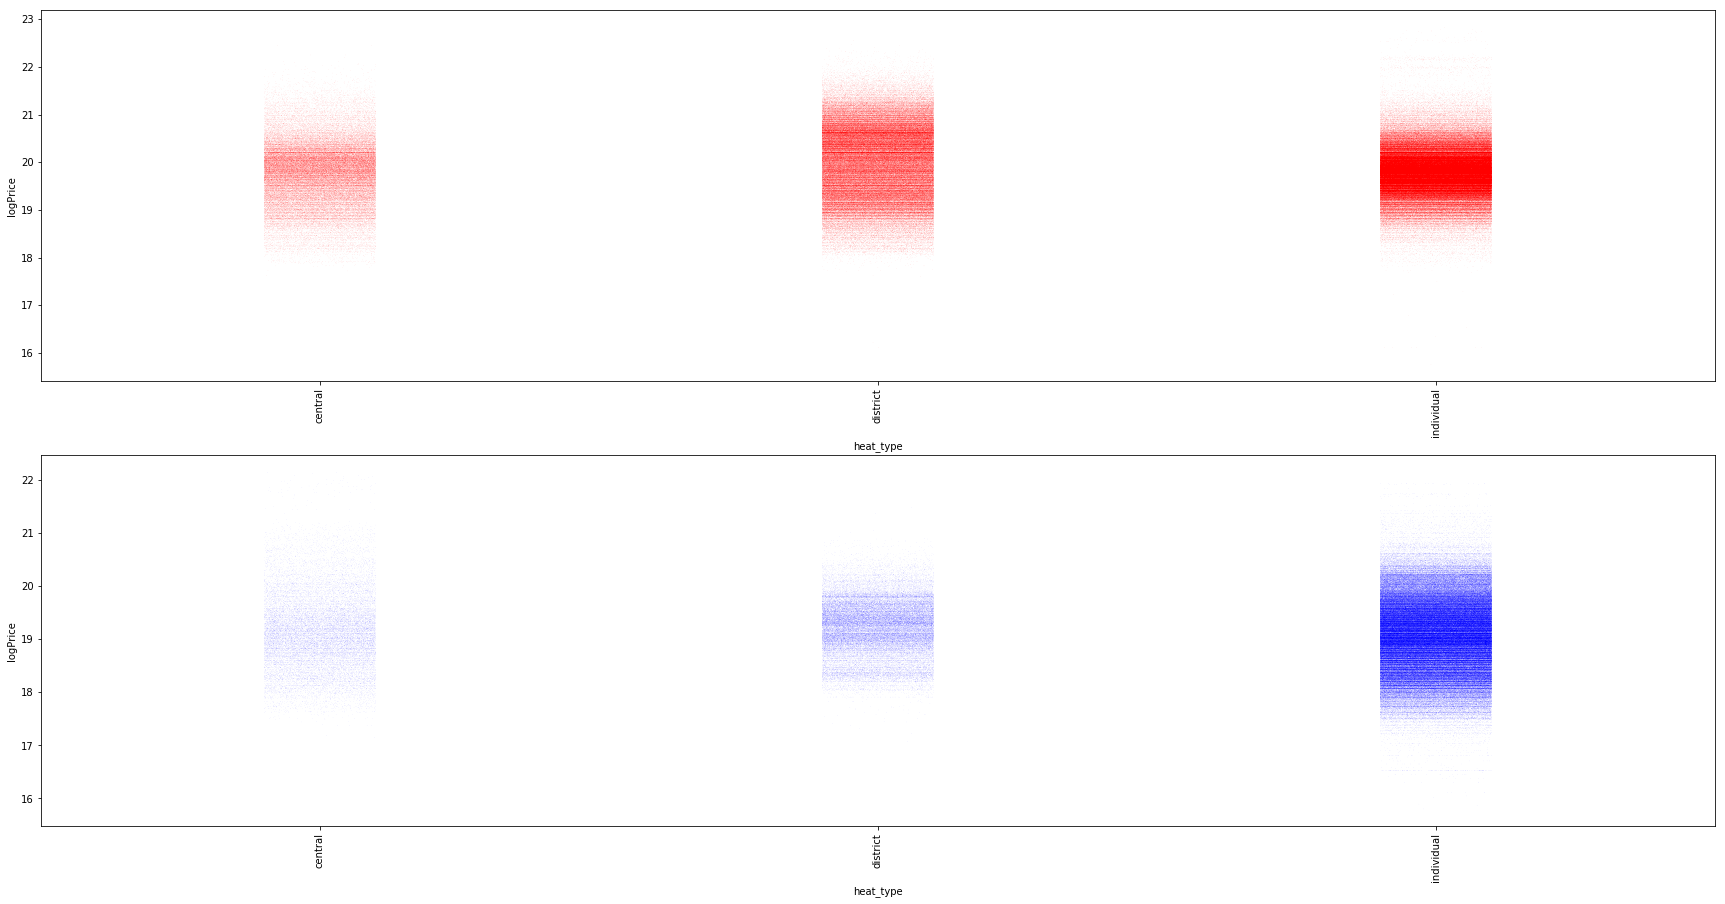

In [29]:
stripSB(col, seoulTrain, busanTrain)

In [88]:
'''
현관 구조 : 집 현관 말고 아파트 복도를 말하는 건가? 아니면 집 바닥이 한층 올라와서 구별되어 있는 거?
'''
col = 'front_door_structure'
colInfo(col)

object
stairway    1146251
corridor     415209
mixed         26085
NaN           13892
-                21
Name: front_door_structure, dtype: int64
stairway    3027
corridor     776
mixed         69
NaN           45
-              1
Name: front_door_structure, dtype: int64
train na :  13892
test na : 45


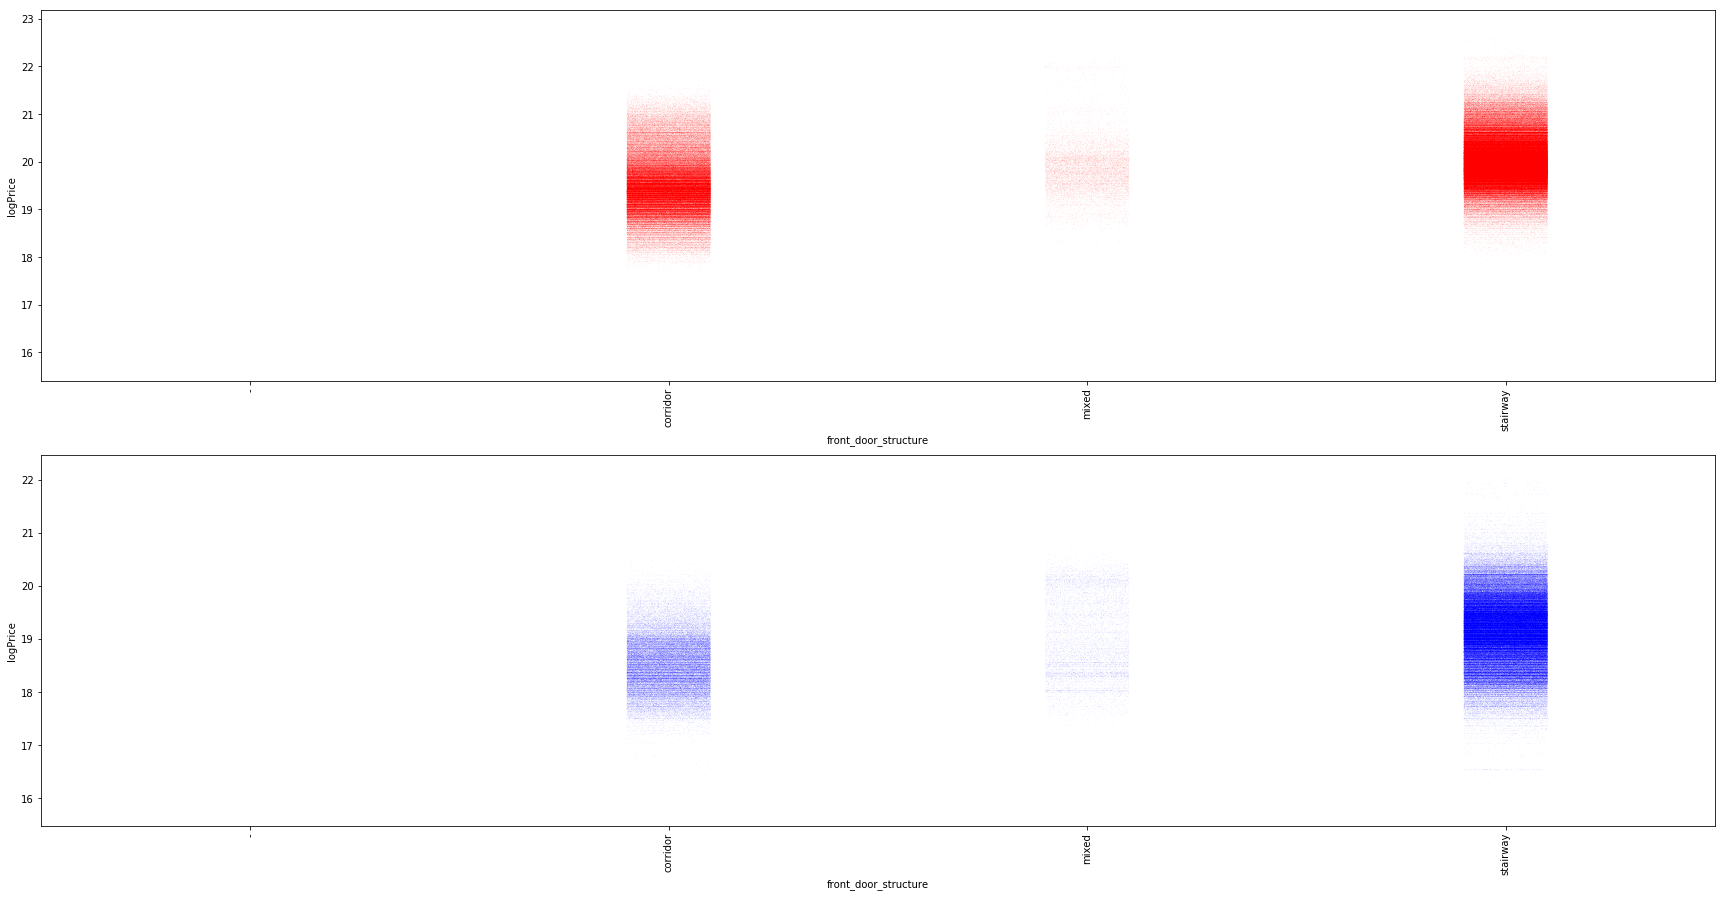

In [31]:
stripSB(col, seoulTrain, busanTrain)

#### corr matrix

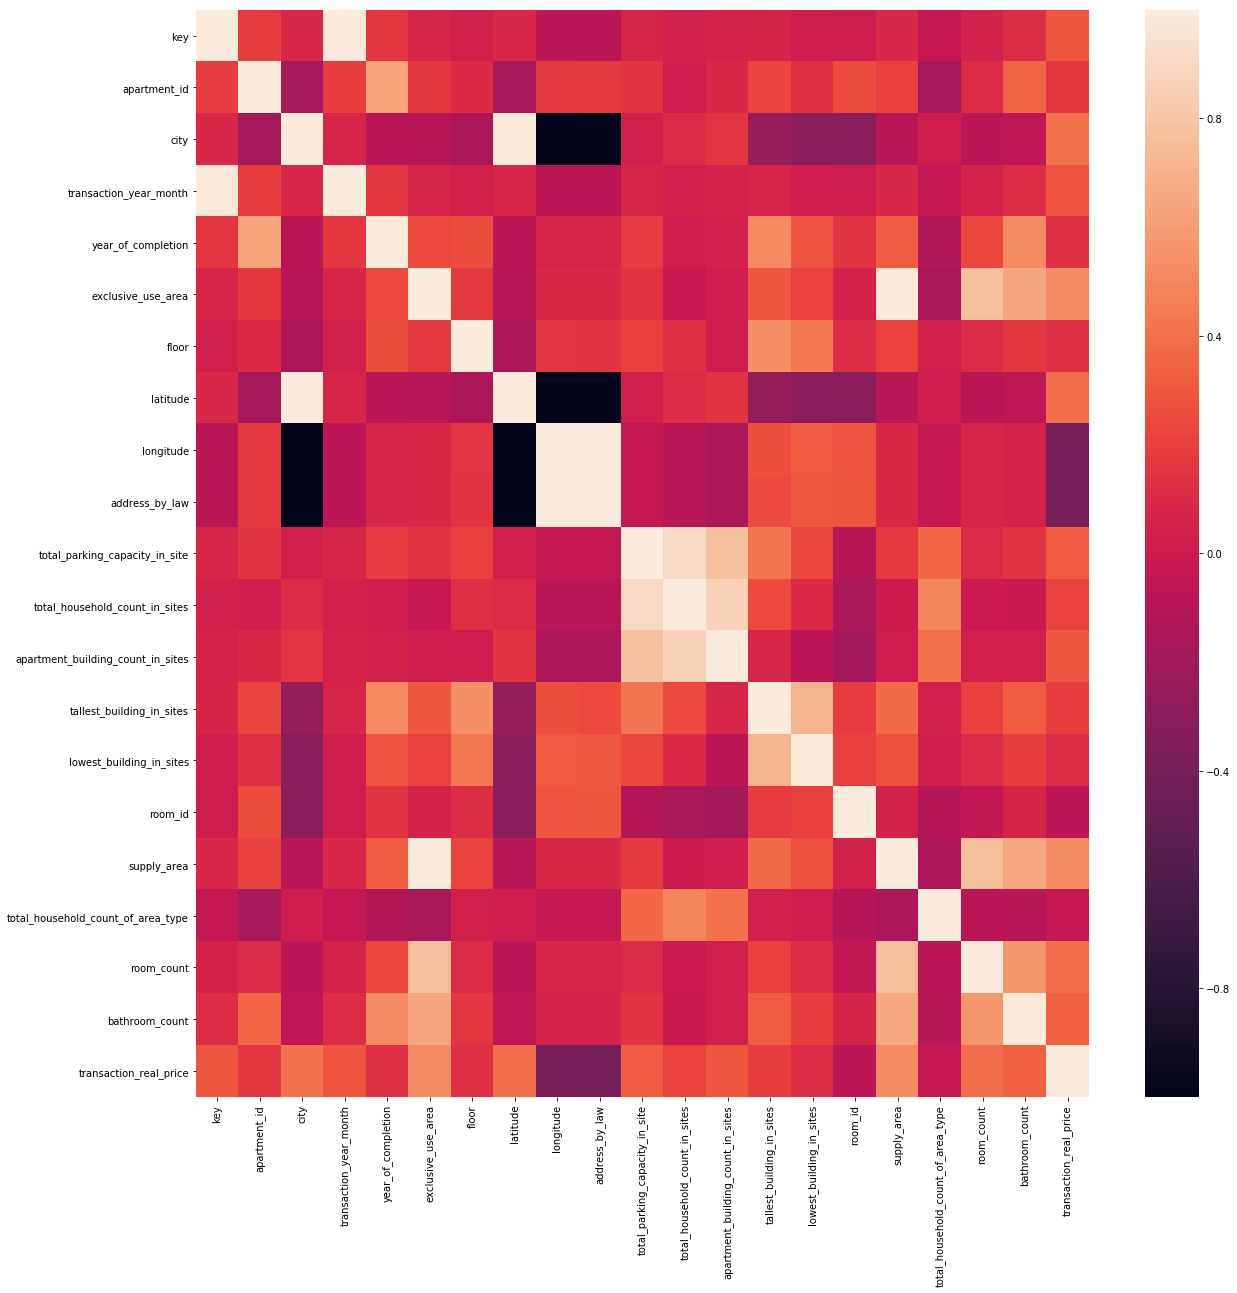

In [39]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax = 1);

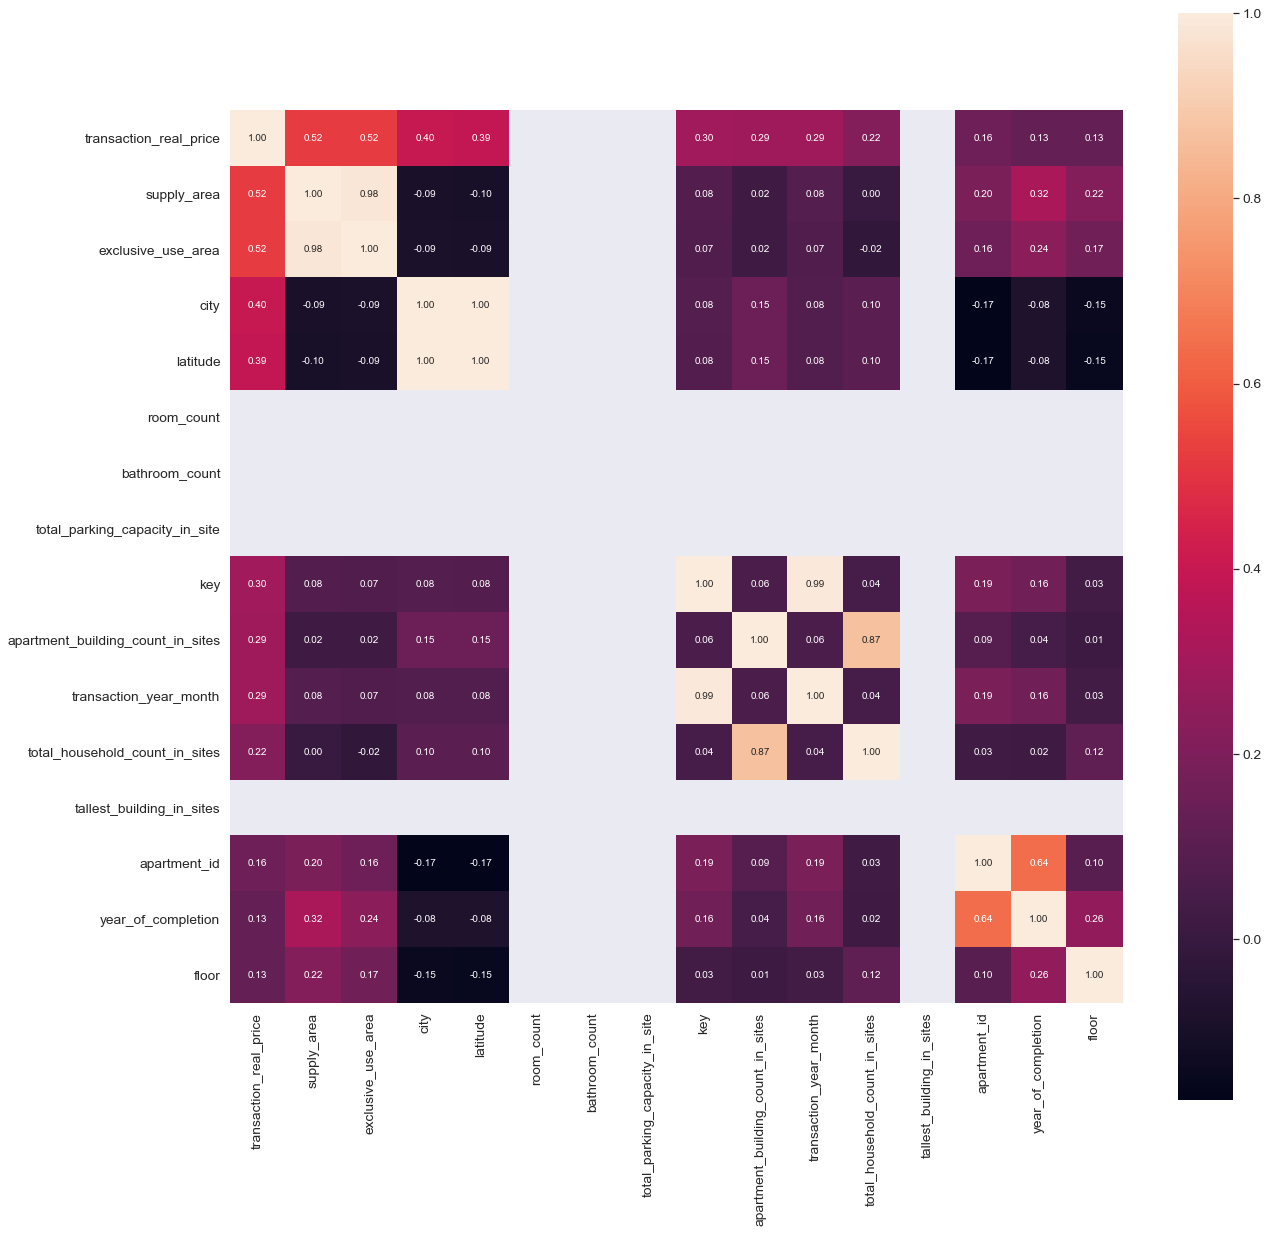

In [40]:
#saleprice correlation matrix
k = 16 #number of variables for heatmap
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(20, 20))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### train과 test의 key는 train & test 셋으로 나누기 전의 인덱스 즉, 원래 고유 인덱스

In [12]:
# 합쳐봅시다.
data = pd.concat([train, test]).sort_values('key').set_index('key')

#### 아파트 아이디 = 단지, 일반적으로 단지별로 아파트 가격 형성

In [10]:
np.sort(np.array(list(set(data.apartment_id)))).shape

(3918,)

총 단지 개수 3918개

In [11]:
print(np.sort(np.array(list(set(data[data.city == 1].apartment_id)))).shape)
print(np.sort(np.array(list(set(data[data.city == 0].apartment_id)))).shape)

(2637,)
(1281,)


서울 아파트 단지: 2637개

부산 아파트 단지: 1281개

#### (중요!) 각 아파트 단지 별 test set 1개로 구성

- 1) 아파트 단지별 test 1개씩이니 일반적으로 단지 시세를 고려하는 것이 필요 (지역시세)
- 2) 각 지역별 시계열 성 역시 고려 필요
- ** 단 아파트 단지에 거래 정보가 1개인 단지 역시 존재 (이 경우 1개가 테스트 케이스). 이 경우 적절한 방법을 통해 가격을 추정해야 함
- ** 적절한 방법은 한 번 봅시다.

#### 아파트 단지네 테스트 케이스가 1개인 단지는 몇개일까

#### 서울부터 봅시다

In [12]:
seoul_apt_id = np.sort(np.array(list(set(data[data.city == 1].apartment_id))))

In [13]:
seoul_cnt_by_apt_id = []
for v in seoul_apt_id:
    seoul_cnt_by_apt_id.append({"apt_id": v, "total_count": len(data[data.apartment_id == v]), "test_count": np.sum((data[data.apartment_id == v]).transaction_real_price == 0) * 1})

In [14]:
seoul_cnt_by_apt_id = pd.DataFrame(seoul_cnt_by_apt_id)

In [20]:
seoul_cnt_by_apt_id[seoul_cnt_by_apt_id.total_count < 40]

apt_id  test_count  total_count
35       100           1           29
129      316           1            2
277      710           1            9
382      989           1           23
426     1136           1           35
446     1179           1           32
496     1299           1           34
907     3751           1            3
1154    4377           1           27
1287    5364           1           26
1895   10924           1           28
1960   11908           1           34
1987   12304           1           20
2013   14029           1           39
2175   18263           1           28
2197   18408           1           39
2225   18702           1           29
2400   20786           1           36
2441   22241           1            2
2442   22247           1            1
2446   22452           1           18
2447   22513           1           14
2479   24243           1           13
2500   25051           1           35
2509   25442           1           23
2531   33198           1            9
2535   33266           1           28
2539   33273           1            7
2546   33300           1           21
2548   33302           1           33
...      ...         ...          ...
2601   36412           1            9
2602   36413           1            4
2604   36469           1           16
2605   36524           1           18
2606   36561           1           38
2607   36764           1           36
2608   36796           1           39
2609   36841           1            1
2610   36892           1           19
2611   36900           1            9
2612   36912           1           12
2613   36917           1           34
2614   36919           1            5
2615   36948           1            4
2616   36952           1           10
2617   36992           1           13
2618   37079           1            8
2619   37081           1            5
2622   37180           1            1
2623   37181           1            9
2624   37242           1            4
2625   37353           1            1
2626   37354           1            1
2627   37431           1            1
2628   37467           1            4
2629   37470           1            4
2630   38129           1           18
2631   38419           1            2
2632   38423           1            5
2633   38438           1            6

[86 rows x 3 columns]